# Load Libraries

In [1]:
import sys, os, pygmt, importlib, re, base64, glob
import numpy              as np
import pandas             as pd
import xarray             as xr
import xesmf              as xe
import netCDF4            as nc
import matplotlib.pyplot  as plt
import matplotlib.dates   as mdates
from matplotlib.offsetbox import AnchoredOffsetbox, VPacker, TextArea
from datetime             import timedelta, date, datetime
from pathlib              import Path
from dask.distributed     import Client, LocalCluster
from collections          import defaultdict
from scipy.interpolate    import interp1d
from pyproj               import CRS, Transformer
from IPython.display      import Image, HTML, Video
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox      import SeaIceToolbox

## reload SeaIceToolbox if local changes have been made

In [ ]:
import sys
import importlib
# Step 1: Clear all relevant modules
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
# Step 2: Explicit reloads in dependency order
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
# Step 3: Re-import key class from module (to refresh the class definition)
from sea_ice_toolbox import SeaIceToolbox

# [Simulation Table](https://dpath2o.github.io/AFIM/ice_diag_summary.html)

# [Methodology](https://dpath2o.github.io/AFIM/AFIM_sensitivity_methodology.html)

# ACCESS-OM2-025-ERA5 sea ice data ( **needs only to be run once, after which data can be extracted from local zarr files** )
+ this uses [ACCESS-NRI intake catalog](https://access-nri-intake-catalog.readthedocs.io/en/latest/index.html) through a ``SeaIceToolbox`` method ``load_ACCESS_OM_CICE``

In [ ]:
dt0_str        = "1993-01-01"
dtN_str        = "1999-12-31"
dt_rng_str     = f"{dt0_str[:4]}-{dtN_str[:4]}"
ice_type       = "FI_BT"
SIA_dict       = {}
FIA_dict       = {}
SI_tools       = SeaIceToolbox(sim_name             = "AOM2-ERA5",
                               dt0_str              = dt0_str,
                               dtN_str              = dtN_str,
                               ice_speed_threshold  = 5e-4,
                               ice_speed_type       = "BT",
                               ice_type             = "FI_BT",
                               overwrite_zarr       = True,
                               save_new_figs        = True,
                               show_figs            = True,
                               overwrite_saved_figs = True)

## load ACCESS-OM-025-ERA5 data from ESM datastore then convert to zarr files for easy of use later
+ loading and saving only needs to be done if it has not been done previously
+ running both of these cells takes approximately an hour with the bottleneck at writing to zarr

In [ ]:
AOM2 = SI_tools.load_ACCESS_OM_CICE()

In [ ]:
SI_tools.write_ACCESS_to_monthly_zarr(AOM2, overwrite=True)

## run ACCESS-OM-025-ERA5 through fast ice classification workflow
+ this is a quick process and will save masked zarr dataset

In [ ]:
AOM2_FI_raw = SI_tools.process_daily_cice(ispd_thresh=5e-4,
                                          ivec_type="BT",
                                          overwrite_zarr_group=True)

In [ ]:
AOM2_FI_roll = SI_tools.process_rolling_cice(ispd_thresh=5e-4,
                                             ivec_type="BT",
                                             overwrite_zarr_group=True)

# <span style="color: red;">Study Objectives</span>

## Can a realistic simulation of circumpolar Antarctic fast ice be achieved in CICE-standalone?

+ Sea ice area and volum comparisons are done against [NSIDC](https://nsidc.org/data/g02202/versions/4) and [ACCESS-OM2-025-IAF-ERA](https://forum.access-hive.org.au/t/era-5-forced-access-om2-simulations/1103) (``AOM2-ERA``). The rationale is to show two of my simulations ([AFIM](https://github.com/dpath2o/AFIM), *CICE6-standalone*) against both NSIDC and ACCESS-OM2 as a relative overall gauge of AFIM performance.

+ I've chosen two related AFIM simulations: ``elps-min`` and ``gi-nil``. Both of which have ellispse eccentrincities ($e_{f}=e_{g}=1.2$, and further just abbreviated $e$) and tensile stress parameter ($k_{t}=0.2$) and all other CICE namelist parameters set to *default* standalone configuration, with the exception of the landmask file used (``kmt_file``). ``elps-min`` uses a modified landmask where 25% of the non-isolated grounded iceberg cells remain, whereas ``gi-nil`` uses the same landmask file as ``AOM2-ERA5`` and hence has no grounded iceberg cells.
  
+ Animations of daily sea ice speed ($\sqrt{u^2 + v^2}$) are then shown of the above two AFIM simulations along with AOM2-ERA5 for the same period (Austral winter 1999). Implicitly, the animations show the effect of $e$ and $ktens$ on the coastal icepack, and for the ``elps-min`` simulation the animation clearly shows the significance of grouned icebergs. 

### Sea Ice Area and Volume Comparisons

In [2]:
def sort_time(ds):
    return ds.sortby("time")
files = sorted(glob.glob("/g/data/gv90/da1339/SeaIce/ESA_CCI/L2P/envisat/sh/ESACCI-SEAICE-L2P-SITHICK-RA2_ENVISAT-SH-*.nc"))
ESA_CCI = xr.open_mfdataset(files, combine="nested", concat_dim="time", preprocess=sort_time, parallel=False)

In [11]:
SIA_dict    = {}
SIV_dict    = {}
FIA_dict    = {}
FIV_dict    = {}
sim_names   = ["gi-max","gi-mid","gi-nil","gi-nil-def","ndte-max","ndte-min","re-evp-off",
               "Cstar-max","Cstar-min","Pstar-max","Pstar-min","elps-ext","elps-min","elps-mid","elps-max",
               "ktens-ext","ktens-max","ktens-min","ktens-nil","ry93","AOM2-ERA5"]
G_CMEMS     = xr.open_dataset("/g/data/gv90/da1339/grids/GLORYS/CMEMS_0p25_grid.nc").rename_dims({'x':'longitude','y':'latitude'})
CMEMS_SI    = xr.open_mfdataset("/g/data/gv90/da1339/SeaIce/CMEMS/0p25/daily/199*_CMEMS_org.nc")
G_CMEMS_SO  = G_CMEMS.isel(latitude=slice(0,340))
CMEMS_SI_SO = CMEMS_SI.isel(latitude=slice(0,340))
for sim in sim_names:
    SI_tools      = SeaIceToolbox(sim_name = sim)
    CICE_all      = SI_tools.load_iceh_zarr()
    CICE_SO       = CICE_all.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
    SIA_dict[sim] = SI_tools.compute_ice_area(CICE_SO['aice'], CICE_SO['tarea'], ice_area_scale=SI_tools.SIC_scale)
    SIV_dict[sim] = SI_tools.compute_ice_volume(CICE_SO['aice'], CICE_SO['hi'], CICE_SO['tarea'])
NSIDC                  = SI_tools.compute_NSIDC_metrics()
SIA_dict['NSIDC']      = NSIDC['SIA']
SIA_dict['CMEMS-ORAS'] = SI_tools.compute_ice_area(CMEMS_SI_SO['siconc_oras'], G_CMEMS_SO['area'], ice_area_scale=1e6, spatial_dim_names=("latitude","longitude"))
SIV_dict['CMEMS-ORAS'] = SI_tools.compute_ice_volume(CMEMS_SI_SO['siconc_oras'], CMEMS_SI_SO['sithick_oras'], G_CMEMS_SO['area'], ice_volume_scale=1e6, spatial_dim_names=("latitude","longitude"))

2025-07-04 08:18:47,920 - INFO - log file initialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_gi-max.log
INFO:gi-max:log file initialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_gi-max.log
2025-07-04 08:18:47,924 - WARNING - Dask client already exists but was not passed to SeaIceToolbox.
2025-07-04 08:18:47,926 - WARNING - Please explicitly pass the existing Dask client using `client=...` to avoid confusion.
2025-07-04 08:18:47,929 - INFO - Dask distributed client can be accessed at url /proxy/8787/status
INFO:gi-max:Dask distributed client can be accessed at url /proxy/8787/status
2025-07-04 08:18:47,933 - INFO - hemisphere initialised: SH
INFO:gi-max:hemisphere initialised: SH
2025-07-04 08:18:48,013 - INFO - Loading monthly Zarr files: /g/data/gv90/da1339/afim_output/gi-max/zarr
INFO:gi-max:Loading monthly Zarr files: /g/data/gv90/da1339/afim_output/gi-max/zarr
2025-07-04 08:19:49,587 - INFO - Loaded 84-zarr files covering 2556 time steps from 1993-01-01 to 1999-12-31
INFO

In [35]:
def convert_stats_dict_to_xarray(stats_dict):
    sim_names = list(stats_dict.keys())
    scalar_vars = {}
    for sim in sim_names:
        for metric_group, metrics in stats_dict[sim].items():
            if isinstance(metrics, xr.DataArray):  # skip time series here
                continue
            for metric_name, value in metrics.items():
                var_key = f"{metric_group}_{metric_name}".replace(" ", "_").replace("-", "_")
                if var_key not in scalar_vars:
                    scalar_vars[var_key] = []
                scalar_vars[var_key].append(value)
    scalar_da_dict = {key: xr.DataArray(data=np.array(vals),
                                        dims=["simulation"],
                                        coords={"simulation": sim_names},
                                        name=key) for key, vals in scalar_vars.items()}
    time_series_da = {}
    for var_name in ['SIA', 'SIV']:
        ts_list = []
        for sim in sim_names:
            da = stats_dict[sim].get(var_name)
            if da is None:
                raise ValueError(f"Missing {var_name} for {sim}")
            da = da.expand_dims({"simulation": [sim]})
            da = da.chunk({"time": 180})  # uniform rechunking
            ts_list.append(da)
        time_series_da[var_name] = xr.concat(ts_list, dim="simulation")
    ds = xr.Dataset({**scalar_da_dict, **time_series_da})
    return ds

In [ ]:
SI_tools  = SeaIceToolbox(sim_name = "elps-min")
sim_names = ["gi-max","gi-mid","gi-nil","gi-nil-def","ndte-max","ndte-min","re-evp-off",
               "Cstar-max","Cstar-min","Pstar-max","Pstar-min","elps-ext","elps-min","elps-mid","elps-max",
               "ktens-ext","ktens-max","ktens-min","ktens-nil","ry93","AOM2-ERA5","CMEMS-ORAS"]
pack_ice_stats = {}
for sim in sim_names:
    print(f"processing {sim}")
    pack_ice_stats[sim] = {}
    pack_ice_stats[sim]['SIA']        = SIA_dict[sim]
    pack_ice_stats[sim]['SIV']        = SIV_dict[sim]    
    pack_ice_stats[sim]['SIA_season'] = SI_tools.compute_seasonal_statistics(SIA_dict[sim], 
                                                                               growth_range        = (71, 273),
                                                                               retreat_early_range = (273, 330),
                                                                               retreat_late_range1 = (331, 365),
                                                                               retreat_late_range2 = (1, 71))
    pack_ice_stats[sim]['SIA_skills'] = SI_tools.compute_statistics(SIA_dict[sim], SIA_dict["NSIDC"])
    pack_ice_stats[sim]['SIV_season'] = SI_tools.compute_seasonal_statistics(SIV_dict[sim], 
                                                                               growth_range        = (71, 273),
                                                                               retreat_early_range = (273, 330),
                                                                               retreat_late_range1 = (331, 365),
                                                                               retreat_late_range2 = (1, 71))
    #pack_ice_stats[sim]['SIV_skills']   = SI_tools.compute_statistics(SIV_dict[sim], SIV_dict["ESA_CCCI"])
PI_DS = convert_stats_dict_to_xarray(pack_ice_stats)
PI_DS.to_zarr("/g/data/gv90/da1339/afim_output/pack_ice.zarr", mode="w")

2025-07-04 09:48:55,569 - WARNING - Dask client already exists but was not passed to SeaIceToolbox.
2025-07-04 09:48:55,572 - WARNING - Please explicitly pass the existing Dask client using `client=...` to avoid confusion.
2025-07-04 09:48:55,576 - INFO - Dask distributed client can be accessed at url /proxy/8787/status
INFO:elps-min:Dask distributed client can be accessed at url /proxy/8787/status
2025-07-04 09:48:55,579 - INFO - hemisphere initialised: SH
INFO:elps-min:hemisphere initialised: SH


processing gi-max
processing gi-mid
processing gi-nil
processing gi-nil-def
processing ndte-max
processing ndte-min
processing re-evp-off
processing Cstar-max
processing Cstar-min
processing Pstar-max
processing Pstar-min
processing elps-ext
processing elps-min
processing elps-mid
processing elps-max
processing ktens-ext
processing ktens-max
processing ktens-min
processing ktens-nil
processing ry93
processing AOM2-ERA5
processing CMEMS-ORAS


In [37]:
#PI_DS = convert_stats_dict_to_xarray(pack_ice_stats)
PI_DS_cnk = PI_DS.chunk({'time':180})
PI_DS_cnk.to_zarr("/g/data/gv90/da1339/afim_output/pack_ice.zarr", mode="w")

In [97]:
PI_DS.sel(simulation="elps-min")

<xarray.Dataset> Size: 41kB
Dimensions:                        (time: 2556)
Coordinates:
    simulation                     <U10 40B 'elps-min'
  * time                           (time) datetime64[ns] 20kB 1993-01-01 ... ...
Data variables: (12/48)
    SIA_season_Maximum_Mean        float64 8B 18.29
    SIA_season_Maximum_Std         float64 8B 0.08364
    SIA_season_Minimum_Mean        float64 8B 1.581
    SIA_season_Minimum_Std         float64 8B 0.2953
    SIA_season_Growth_Mean         float64 8B 9.001e+04
    SIA_season_Growth_Std          float64 8B 2.024e+03
    ...                             ...
    SIV_season_DOY_Max_Mean        float64 8B 285.8
    SIV_season_DOY_Max_Std         float64 8B 6.177
    SIV_season_DOY_Onset_Mean      float64 8B 64.6
    SIV_season_DOY_Onset_Std       float64 8B 3.137
    SIA                            (time) float32 10kB dask.array<chunksize=(170,), meta=np.ndarray>
    SIV                            (time) float32 10kB dask.array<chunksize=(170,), meta=np.ndarray>

In [143]:
def extract_skill_metrics(stats_dict, group="SIA_skills"):
    """
    Extract skill metrics (e.g., Bias, RMSE, Corr, etc.) for each simulation.
    Returns a DataFrame with simulations as rows and skill metrics as columns.
    """
    rows = []
    for sim, sim_dict in stats_dict.items():
        metrics = sim_dict.get(group, {})
        rows.append(pd.Series(metrics, name=sim))
    return pd.DataFrame(rows)

def extract_seasonal_stats_df(ds, prefix="SIA_season"):
    """
    Extract tidy DataFrame of mean/std seasonal stats from an xarray.Dataset,
    matching variable names in a case-insensitive way.
    """
    import re
    records = []
    prefix_lower = prefix.lower()
    for var in ds.data_vars:
        var_lower = var.lower()
        if var_lower.startswith(prefix_lower) and var_lower.endswith("_mean"):
            # Extract metric name (e.g., "growth") from original var
            base = var[len(prefix) + 1:-5]  # preserve original case
            std_var_candidates = [v for v in ds.data_vars if v.lower() == f"{prefix.lower()}_{base.lower()}_std"]
            if std_var_candidates:
                std_var = std_var_candidates[0]
                for sim in ds.simulation.values:
                    records.append({
                        "Simulation": sim,
                        "Metric": base.replace("_", " "),  # optional: format name
                        "Mean": ds[var].sel(simulation=sim).item(),
                        "Std": ds[std_var].sel(simulation=sim).item()
                    })
    return pd.DataFrame.from_records(records)

def normalise_columnwise(df, signed_cols=None):
    """
    Normalise all columns to [0, 1], but handle `signed_cols` (e.g., Bias) using symmetric scaling to [-1, 1] → rescale to [0, 1].
    """
    df_norm = df.copy()
    signed_cols = signed_cols or []
    for col in df.columns:
        if col in signed_cols:
            max_abs = df[col].abs().max()
            df_norm[col] = (df[col] / max_abs + 1) / 2  # maps [-max, max] → [0, 1]
        else:
            df_norm[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df_norm

def format_heatmap_annotations(df, digits_dict):
    """
    Format the values of df using digits_dict, e.g., {'Bias': 2, 'Corr': 3}
    """
    formatted = df.copy().astype(str)
    for col in df.columns:
        digits = digits_dict.get(col, 2)
        formatted[col] = df[col].apply(lambda x: f"{x:.{digits}f}")
    return formatted

def plot_skill_heatmap(df_skills, normalise=False, cmap="viridis", P_png=None):
    import seaborn as sns
    digits_dict = {"Bias": 3,
                   "RMSE": 3,
                   "MAE" : 3,
                   "Corr": 3,
                   "SD_Model": 3,
                   "SD_Obs": 3}
    annot_df = format_heatmap_annotations(df_skills, digits_dict)
    df_plot = df_skills.copy()
    if normalise:
        df_plot = normalize_columnwise(df_skills, signed_cols=["Bias"])
    else:
        df_plot = df_skills.copy()
    plt.figure(figsize=(12, len(df_plot) * 0.4))
    sns.heatmap(df_plot, annot=annot_df.values, fmt="", cmap=cmap, cbar=True, linewidths=0.5 )
    #plt.title("Skill Metrics by Simulation" + (" (Normalised)" if normalise else ""))
    plt.ylabel("Simulation")
    plt.xlabel("Metric")
    plt.tight_layout()
    if P_png:
        plt.savefig(P_png)
    plt.show()


def plot_grouped_seasonal_stats(df, ncols=4, height=4, palette="Blues_d", var_type="SIA", P_png=None):
    """
    Plot grouped seasonal stats with error bars using manual subplots.
    
    Parameters
    ----------
    df : DataFrame
        Must contain columns ["Simulation", "Metric", "Mean", "Std"]
    ncols : int
        Number of subplot columns.
    height : float
        Height per subplot.
    palette : str
        Seaborn color palette.
    var_type : str
        One of ["SIA", "SIV", "FIA", "FIV"] to determine y-labels and unit scaling.
    """
    import seaborn as sns
    ylim_dict = {
        ("SIA", "maximum"): (15, 19),
        ("SIA", "minimum"): (0, 2),
        ("SIA", "growth"): (6, 10),
        ("SIA", "retreat"): (-15, -10),
        ("SIA", "duration"): (280, 310),
        ("SIA", "doy min"): (50, 70),
        ("SIA", "doy max"): (225, 275),
        ("SIA", "doy onset"): (50, 70),
    }
    # Filter out unwanted metrics
    df = df[~df["Metric"].isin(["retreat Early", "retreat Late"])]

    metrics = df["Metric"].unique()
    nplots = len(metrics)
    nrows = int(np.ceil(nplots / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * height), sharex=False)
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        sub = df[df["Metric"] == metric].copy()

        # Determine metric display name and units
        metric_lower = metric.lower()
        if metric in ["Growth", "retreat"]:
            metric_name = f"{metric.lower()} rate"
            if var_type in ["SIA", "SIV"]:
                sub["Mean"] = sub["Mean"] / 1e4
                sub["Std"] = sub["Std"] / 1e4
                ylabel = "10^4 km²/day" if var_type == "SIA" else "10⁶ km³/day"
            else:
                ylabel = "10^3 km²/day" if var_type == "FIA" else "10³ km³/day"
        elif metric in ["Maximum", "Minimum"]:
            metric_name = f"{metric.lower()} {var_type}"
            if var_type in ["SIA", "SIV"]:
                ylabel = "10⁶ km²" if var_type == "SIA" else "10⁶ km³"
            else:
                ylabel = "10³ km²" if var_type == "FIA" else "10³ km³"
        elif "duration" in metric_lower or "doy" in metric_lower:
            metric_name = metric_lower.replace("_", " ")
            ylabel = "Day of Year"
        else:
            metric_name = metric.lower()
            ylabel = "Value"

        # Plot
        ax = axes[i]
        sns.barplot(data=sub, x="Simulation", y="Mean", ax=ax, palette=palette)
        ax.errorbar(
            x=np.arange(len(sub)),
            y=sub["Mean"],
            yerr=sub["Std"],
            fmt='none',
            c='k',
            capsize=4,
            lw=1.2
        )
        ax.set_title(metric_name, fontsize=12)
        ax.set_ylabel(ylabel)
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Apply custom ylim if matched
        metric_clean = metric_name.lower().strip().replace("_", " ")
        key = (var_type, metric_clean.split()[0]) if "doy" not in metric_clean else (var_type, metric_clean)
        if key in ylim_dict:
            ax.set_ylim(ylim_dict[key])

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    #fig.suptitle(f"{var_type} Seasonal Statistics Across Simulations", fontsize=16, y=1.02)
    plt.tight_layout()
    if P_png:
        plt.savefig(P_png)
    plt.show()


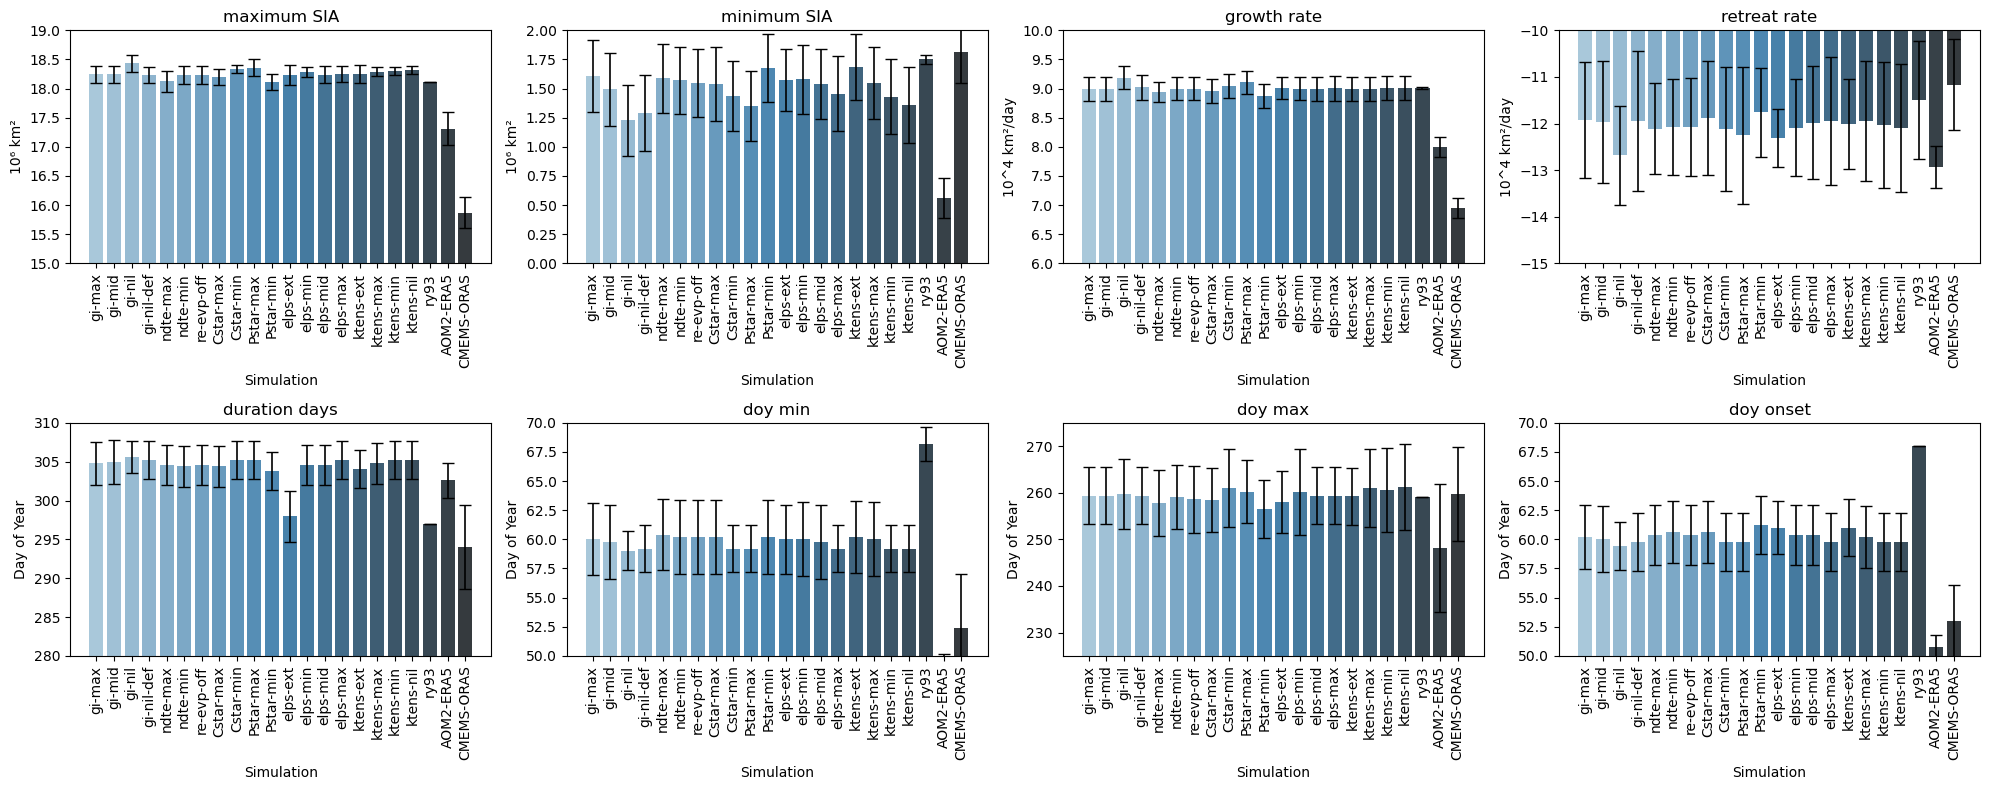

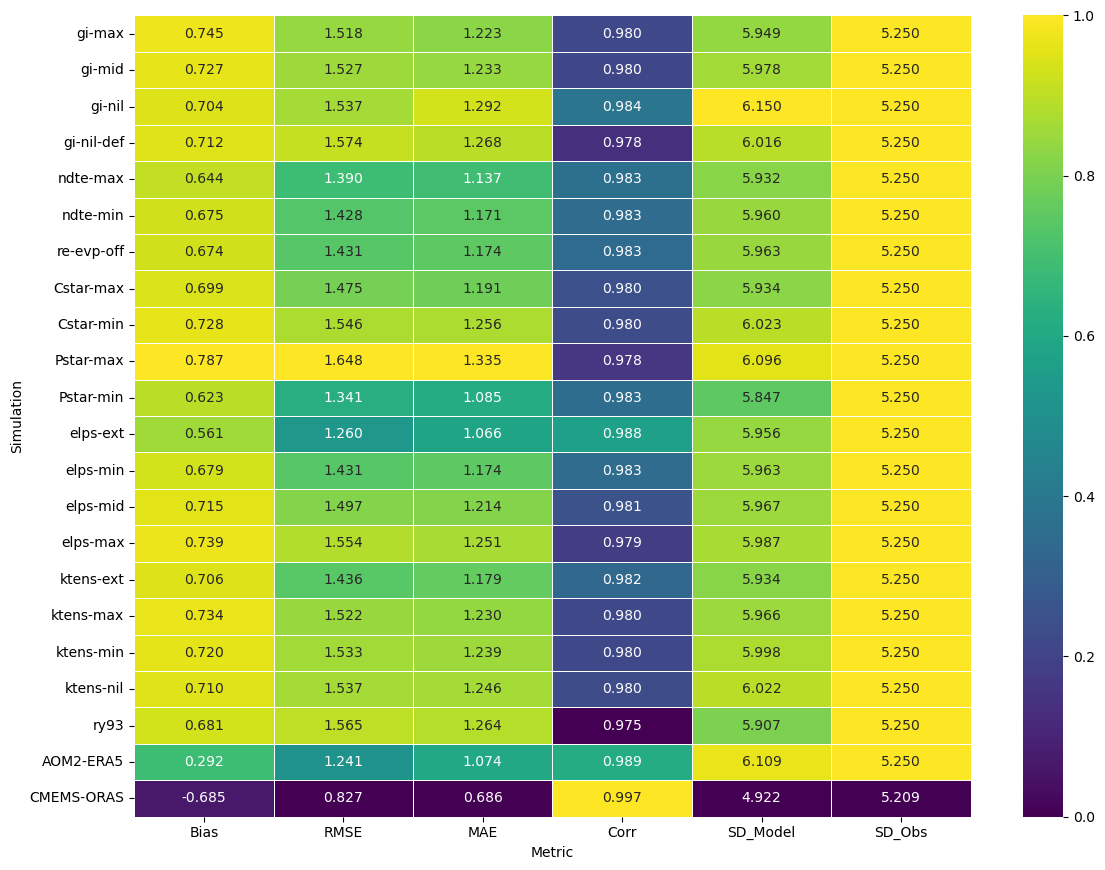

In [145]:
df_skills = extract_skill_metrics(pack_ice_stats, group="SIA_skills")
df_stats = extract_seasonal_stats_df(PI_DS, prefix="SIA_season")
plot_grouped_seasonal_stats(df_stats, var_type="SIA", P_png="/g/data/gv90/da1339/GRAPHICAL/AFIM/SIA_seasonal_stats_all_sims.png")
plot_skill_heatmap(df_skills, normalise=True, P_png="/g/data/gv90/da1339/GRAPHICAL/AFIM/SIA_skill_stats_all_sims.png")

In [ ]:
SI_tools  = SeaIceToolbox(sim_name = sim)
P_png     = Path(SI_tools.D_graph,"timeseries","SIA_elps-min_gi-nil_AOM2-ERA5_1994-1999.png")
SI_tools.plot_monthly_ice_metric_by_year(SIA_dict, ice_type = "SIA", P_png=P_png)
P_png     = Path(SI_tools.D_graph,"timeseries","SIV_elps-min_gi-nil_AOM2-ERA5_1994-1999.png")
SI_tools.plot_monthly_ice_metric_by_year(SIV_dict, ice_type = "SIV", P_png=P_png)

In [ ]:
Image(filename='/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/SIA_elps-min_gi-nil_AOM2-ERA5_1994-1999.png')

In [ ]:
Image(filename='/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/SIV_elps-min_gi-nil_AOM2-ERA5_1994-1999.png')

<a id="spatial-comparisons"></a>
### Spatial Comaprisons 

#### Hemisphere comparisons of sea ice concentration and sea ice thickness

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/elps-min_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``AOM2-ERA5``: e = 2, ktens = None, gi-min = None

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/AOM2-ERA5_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

##### ``gi-nil``: e = 2, ktens = 0.2, gi-min = None

In [ ]:
HTML("""
<video width="1000" controls>
  <source src="https://raw.githubusercontent.com/dpath2o/AFIM/main/docs/figures/gi-nil_ispd_BT_Aus_1999-winter.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

### Which is the best method for computing fast ice: binary-day or rolling-mean?

+ create a dictionary of circumpolar fast ice area time series for one simulation (``elps-min``) for a range of different ``binary-day`` and ``rolling-mean`` configurations
+ calculate relevant statistical skills for each configuration against fast ice area observations (``AF2020``)
+ come up with a metric (normalisation-score) for determining the best performing configuration

In [ ]:
ts_dict    = {}
sim_name   = "elps-min"
dt0_str    = "1993-01-01"
dtN_str    = "1999-12-31"
SI_tools   = SeaIceToolbox(sim_name             = sim_name,
                           dt0_str              = dt0_str,
                           dtN_str              = dtN_str,
                           overwrite_zarr       = True,
                           save_new_figs        = True,
                           show_figs            = True,
                           overwrite_saved_figs = True)

#### compute binary-days 
+ this will be binary-days for 7 out of 7, 6 out of 7, 5 out of 7, 8 out of 8, 7 out of 8, 6 out of 8, and so on, until 13 out of 15.
  

In [ ]:
CICE_SO = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice'])
for win in np.arange(7, 16):  # window sizes: 7 to 15 inclusive
    for cnt in np.arange(win, win - 3, -1):  # max, max-1, max-2 (e.g., 7,6,5)
        key_name = f"elps-min_bin-day_{cnt}of{win}"
        FI_bool              = SI_tools.boolean_fast_ice(FI_raw['FI_mask'], window=win, min_count=cnt)
        CICE_bool            = CICE_SO.where(FI_bool)
        CICE_bool['FI_mask'] = FI_bool
        ts_dict[key_name]    = SI_tools.compute_ice_area(CICE_bool['FI_mask'], CICE_bool.tarea)

#### compute rolling-mean

+ this will be rolling-means over 7, 10, 13, 16 and 19 day periods
+ then compute FIA on each of those

In [ ]:
CICE_rolls   = {}
FI_raw, CICE = SI_tools.load_processed_cice(zarr_CICE = True)
for i in np.arange(7,20,3):
    roll_name             = f"elps-min_roll-day_{i:d}"
    CICE_rolls[roll_name] = SI_tools.process_rolling_cice(sim_name         = "elps-min",
                                                          dt0_str          = "1993-01-01",
                                                          dtN_str          = "1999-12-31",
                                                          mean_period      = i,
                                                          ivec_type        = "BT",
                                                          write_zarr_group = False)
    ts_dict[roll_name] = SI_tools.compute_ice_area(CICE_rolls[roll_name]['FI_mask'], CICE_rolls[roll_name].tarea)

#### compute statistics for each configuration

In [ ]:
ts_ds     = SI_tools.dict_to_ds(ts_dict)
ts_ds_cnk = ts_ds.chunk({'time':30})
ts_ds_cnk.to_zarr(Path(SI_tools.D_sim,"FIA_time-series_multi-bin-days_multi-roll-days.zarr"), mode="w")
AF_clim = SI_tools.load_AF2020_FIA_summary(start="1994-01-01", end="1999-12-31")
obs_fia = SI_tools.AF2020_clim_to_model_time( ts_dict['elps-min_bin-day_7of7'] , AF_clim["FIA_clim"].sel(region="circumpolar"))
ts_dict_stats = {}
for key in ts_dict.keys():
    print(key)
    ts_dict_stats[key] = SI_tools.compute_statistics( ts_dict[key], obs_fia)
    

#### compute a normalised-score to rank the configurations

In [ ]:
df['Abs_Bias'] = np.abs(df['Bias'])
df['SD_Diff']  = np.abs(df['SD_Model'] - df['SD_Obs'])
df['score']    = (df['Abs_Bias'] / df['Abs_Bias'].max() +
                   df['RMSE']     / df['RMSE'].max() +
                   df['MAE']      / df['MAE'].max() +
                   df['SD_Diff']  / df['SD_Diff'].max() +
                   (1 - df['Corr']) / (1 - df['Corr'].min()))
best_method    = df['score'].idxmin()
df_sorted      = df.sort_values(by='score')
print("Best-aligned method with observed FIA:", best_method)
df_sorted[['Bias', 'RMSE', 'MAE', 'Corr', 'SD_Model', 'SD_Obs']].head(5)

#### plot the c

In [ ]:
import seaborn as sns
df = pd.DataFrame.from_dict(ts_dict_stats, orient='index')
df.index.name = "Method"
df.reset_index(inplace=True)
df = df.sort_values(by="Method")
df_heat = df.set_index("Method")[["Bias", "RMSE", "MAE", "Corr"]]
plt.figure(figsize=(12, 10))
sns.heatmap(df_heat, annot=True, cmap="vlag", center=0, fmt=".1f")
plt.title("elps-min simulation FIA skill against observed FIA")
plt.ylabel("binar-day and rolling-mean methods of classifying fast ice from daily-fast-ice-threshold on composite grid")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(Path(SI_tools.D_graph,sim_name,"bin-day_v_roll-mean_methods_FIA_skills_v_obs_FIA.png"))
plt.show()

2025-07-05 16:44:54,696 - INFO - log file initialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_elps-min.log
INFO:elps-min:log file initialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_elps-min.log
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38999 instead
  warnings.warn(
2025-07-05 16:44:59,090 - INFO - Initialized new Dask client.
INFO:elps-min:Initialized new Dask client.
2025-07-05 16:44:59,097 - INFO - Dask distributed client can be accessed at url /proxy/38999/status
INFO:elps-min:Dask distributed client can be accessed at url /proxy/38999/status
2025-07-05 16:44:59,100 - INFO - hemisphere initialised: SH
INFO:elps-min:hemisphere initialised: SH


### Can we realistically simulate the:

1.  fast ice area min

2.  fast ice area max

3.  seasonality

4.  thickness

5.  inter-annual variability

6.  all the while maintaining [pack ice (see above)](#spatial-comparisons)

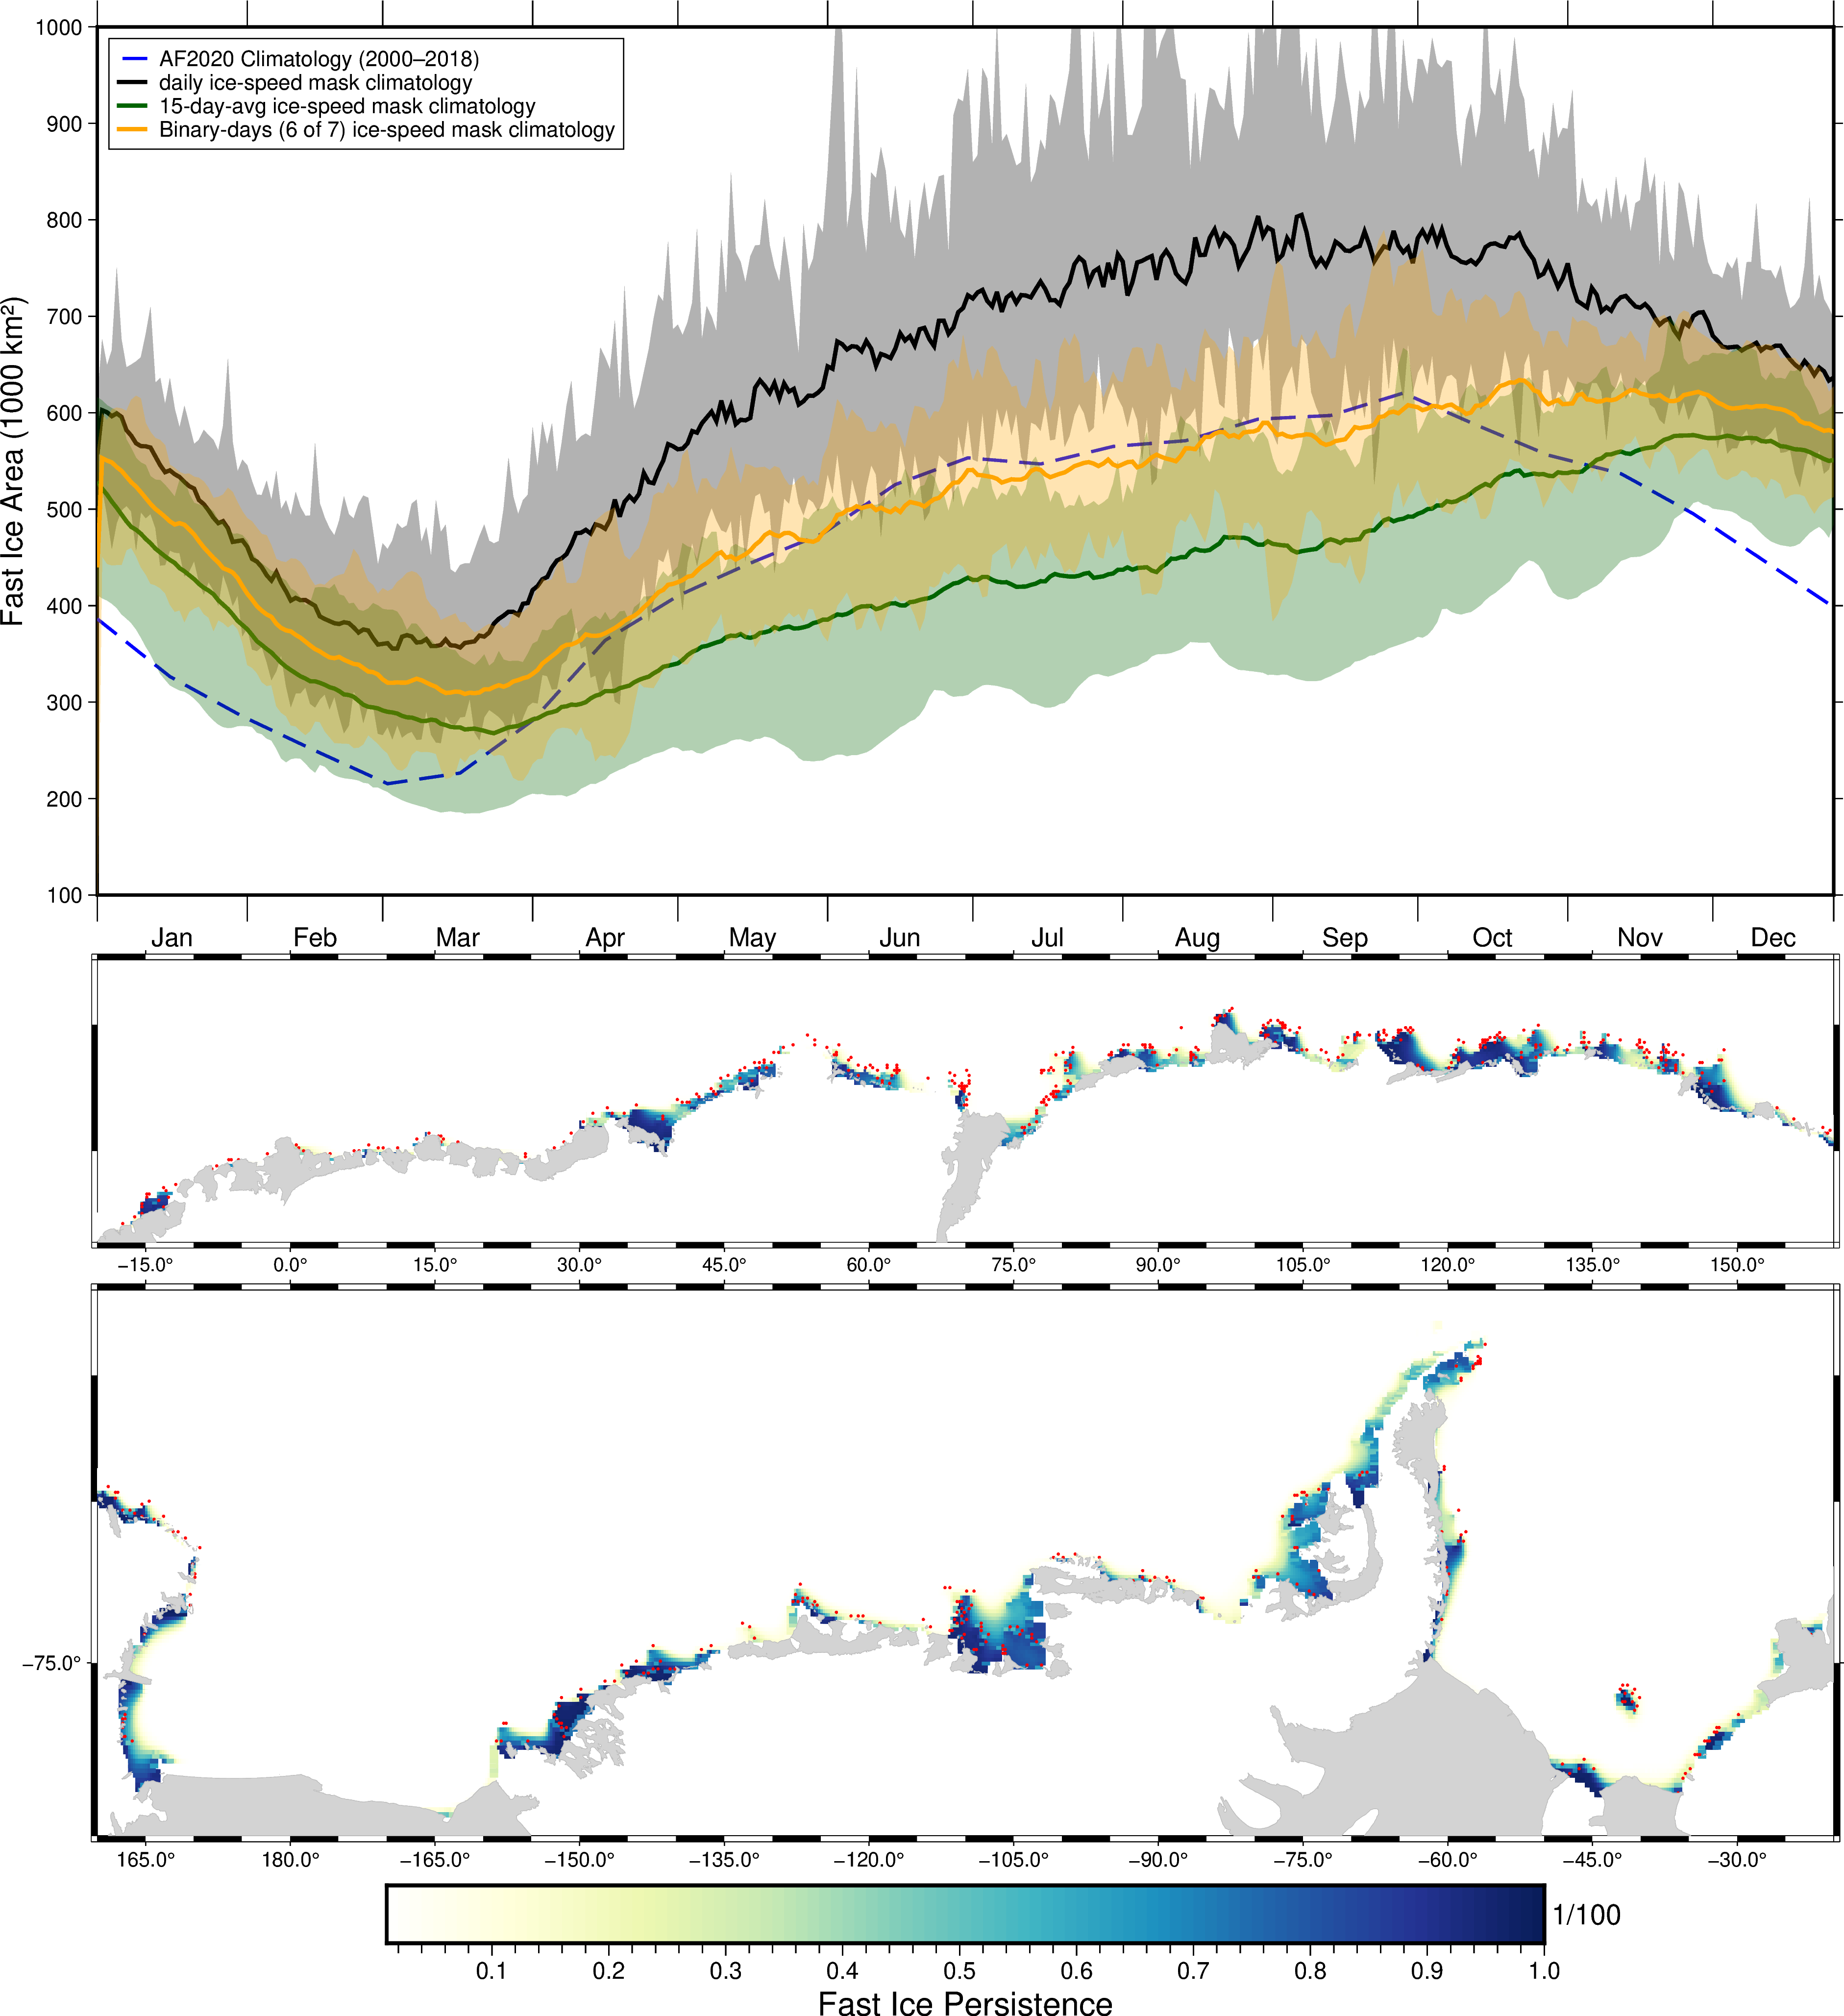

In [16]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_FIP_elps-min_5.0e-4_1993-2023.png")

### Fast ice comparison for simulation ``elps-min`` (and maybe ``elps-mid``)

+ ($e=1.2$, $k_t = 0.2$, $GI_{thin}=0.25$) versus [AF2020 FI db](https://tc.copernicus.org/articles/15/5061/2021/)
+ these results are based on 2000 to 2018 direct comparison
  

#### ``elps-min`` compute FIA and plot both continuous time series and climatology (groupby DOY)

In [ ]:
sim_name = "elps-min"
dt0_str  = "2000-01-01"
dtN_str  = "2018-12-31"
years    = range(2000, 2019)
SI_tools = SeaIceToolbox(sim_name            = sim_name,
                        client               = None,
                        dt0_str              = dt0_str,
                        dtN_str              = dtN_str,
                        ice_speed_threshold  = 5e-4,
                        ice_speed_type       = "ispd_BT",
                        ice_type             = "FI_BT",
                        overwrite_zarr       = False,
                        save_new_figs        = True,
                        show_figs            = False,
                        overwrite_saved_figs = True)
P_FI_diff            = Path(SI_tools.D_sim,f"FI-diff_obs-elps-min_{dt0_str[:3]}-{dtN_str[:3]}.nc")
FI_raw, CICE         = SI_tools.load_processed_cice( zarr_CICE = True )
CICE_SO              = CICE.isel(nj=SI_tools.hemisphere_dict['nj_slice']).persist()
FI_bool              = SI_tools.boolean_fast_ice( FI_raw['FI_mask'] , window=11, min_count=9).compute()
aice_bool            = CICE_SO['aice'].where(FI_bool).compute()
tarea_bool           = CICE_SO['tarea'].where(FI_bool).compute()
D_obs                = Path(SI_tools.AF_FI_dict['D_AF2020_db_org'])
P_orgs               = sorted(D_obs.glob("FastIce_70_*.nc"))
FI_obs               = xr.open_mfdataset(P_orgs, engine='netcdf4', combine='by_coords')
FI_obs               = FI_obs.chunk({'time':1}).compute()
def threshold_mask(block):
    return xr.where(block >= 4, 1, 0)
FI_obs_mask              = FI_obs['Fast_Ice_Time_series'].map_blocks(threshold_mask)
FI_obs_ts                = FI_obs_mask.astype(int)
FI_sim_coar              = SI_tools.coarsen_and_align_simulated_FI_to_observed_FI(FI_bool, FI_obs_ts)
aice_coar                = SI_tools.coarsen_and_align_simulated_FI_to_observed_FI(aice_bool, FI_obs_ts)
tarea_coar               = SI_tools.coarsen_and_align_simulated_FI_to_observed_FI(tarea_bool, FI_obs_ts)
FIA_obs                  = SI_tools.compute_ice_area( FI_obs_ts, FI_obs['area'], ice_area_scale=1e3, spatial_dim_names=('Y','X') , add_grounded_iceberg_area=False)
FIA_sim                  = SI_tools.compute_ice_area( aice_cora, tarea_coar )
FIA_obs_algn, FIA_sim_algn = xr.align(FIA_obs, FIA_coar, join="inner")
FIA_dict                   = {'elps-min' : FIA_sim_algn, 'AF2020' : FIA_obs_algn }
SI_tools.plot_timeseries(FIA_dict,
                        roll_days = None,
                        tit_str   = None,
                        ylim      = None,
                        ylabel    = "Fast Ice Area (1000-km²)",
                        ytick_inc = 100,
                        xlabel    = "Date",
                        xtick_inc = 1,
                        P_png     = Path(SI_tools.D_graph,"timeseries","FIA_elps-min_and_AF2020_2000-2018.png"),
                        fig_width = "30c",
                        fig_height= "10c",
                        legend_pos= "JBL+jBL+o0.1c",
                        legend_box= "+gwhite+p0.1p",
                        pen_weight= "1p",
                        time_coord= "time",
                        keys2plot = None,
                        show_fig  = True)
SI_tools.plot_monthly_ice_metric_by_year(FIA_dict,
                                        ice_type         = "FIA",
                                        roll_days        = 0,
                                        ylim             = None,
                                        figsize          = (18, 10),
                                        tit_str          = None,
                                        P_png            = Path(SI_tools.D_graph,sim_name,"FIA_elps-min_and_AF2020_2000-2018.png"),
                                        tick_fontsize    = 12,
                                        label_fontsize   = 14,
                                        title_fontsize   = 18,
                                        legend_fontsize  = 12,
                                        plot_annotations = False)

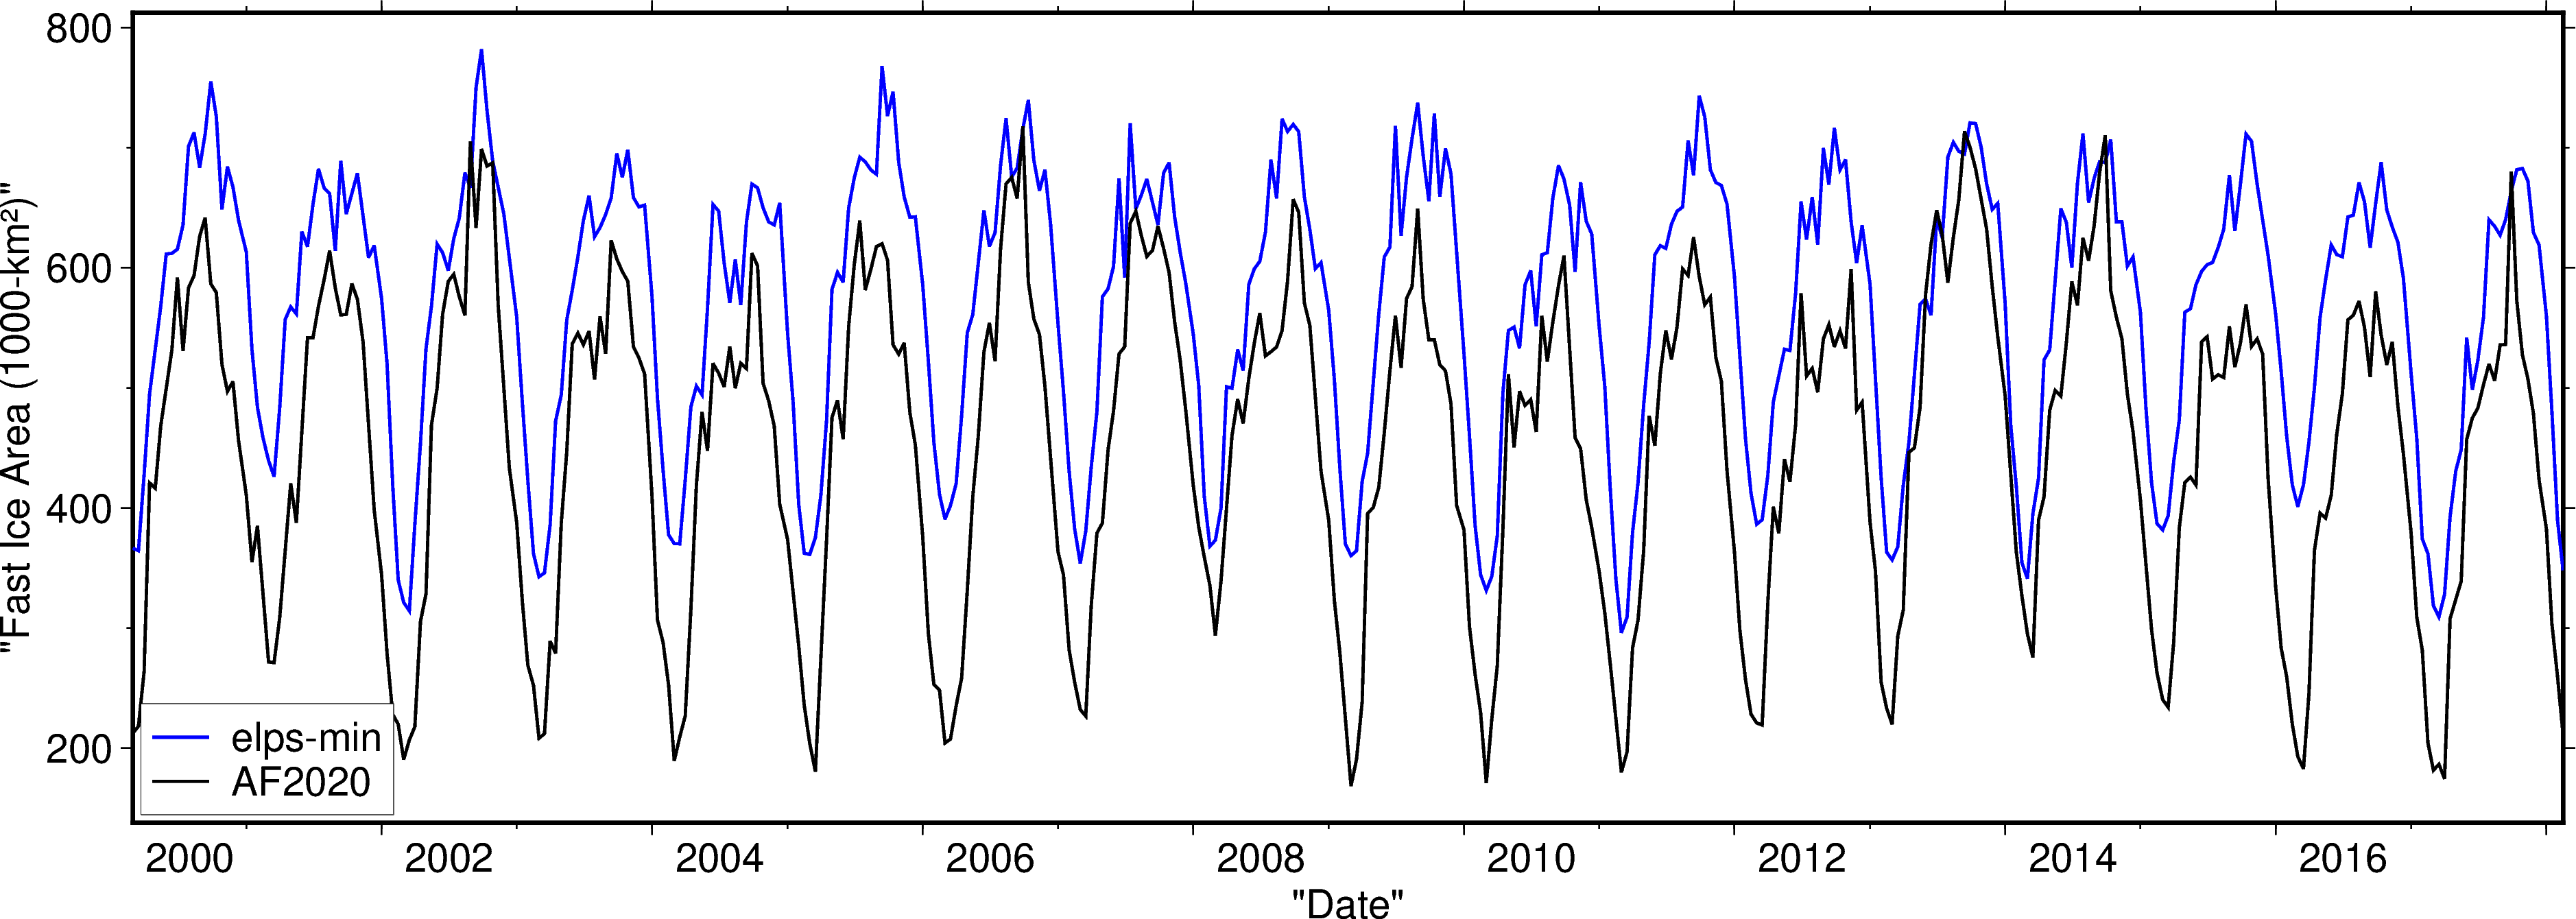

In [5]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps-min_and_AF2020_2000-2018.png")

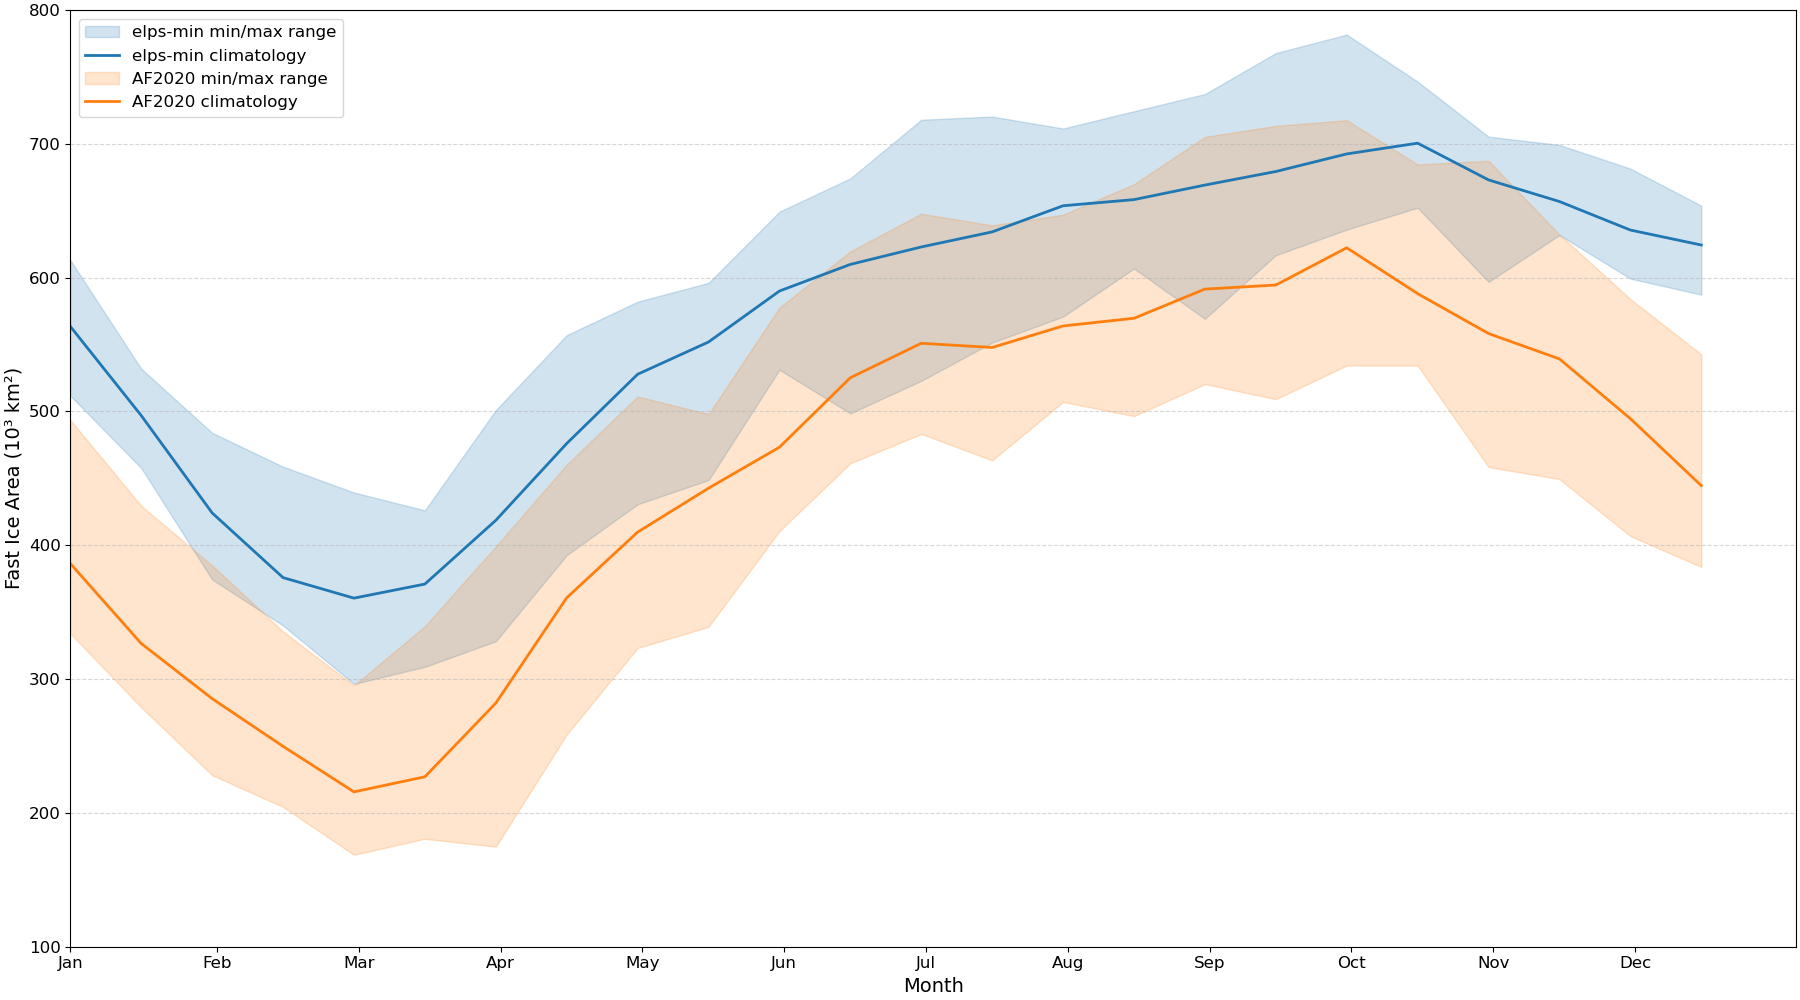

In [ ]:
Image(filename="/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/FIA_elps-min_and_AF2020_2000-2018.png")

##### compute spatial difference for each time-step (432 in total) and plot for 8 Antarctic regions, show animation

+ [create_FI_diff_plots.py](https://github.com/dpath2o/AFIM/blob/main/scripts/plotting/create_FI_diff_plots.py) is responsible for creating these figures

In [6]:
Image()

ValueError: No image data found. Expecting filename, url, or data.

### Seasonality and inter-annual variability

In [ ]:
sim_name            = "elps-min"
SI_tools            = SeaIceToolbox(sim_name = sim_name)
FI_mets             = xr.open_dataset(Path(SI_tools.D_zarr,"ispd_thresh_5.0e-4","metrics","FI_BT_bool_mets.zarr"))
FIA_obs             = SI_tools.load_AF2020_FI_area_timeseries()
FIA_dict            = {}
FIA_dict['FIA_obs'] = FIA_obs
FIA_dict['FIA_sim'] = FI_mets['FIA']
FIA_obs_df          = FIA_dict['FIA_obs']  # pandas DataFrame
FIA_sim             = FIA_dict['FIA_sim']  # xarray DataArray with .time and daily frequency
obs_daily_list      = []
for year in FIA_obs_df['Year'].unique():
    subset     = FIA_obs_df[FIA_obs_df['Year'] == year]
    doys       = ((subset['DOY_start'] + subset['DOY_end']) // 2).values
    dates      = pd.to_datetime(f"{year}-01-01") + pd.to_timedelta(doys - 1, unit='D')
    ts         = pd.Series(subset['circumpolar'].values, index=dates)
    full_range = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31", freq='D')
    ts_daily   = ts.reindex(full_range).interpolate("linear").ffill().bfill()
    obs_daily_list.append(ts_daily)
FIA_obs_daily   = pd.concat(obs_daily_list).sort_index()
sim_dates       = pd.to_datetime(FIA_sim['time'].values)
FIA_obs_aligned = FIA_obs_daily.reindex(sim_dates).interpolate("linear").ffill().bfill()
FIA_obs_aligned = FIA_obs_aligned/1e3
FIA_sim_smooth  = FIA_sim.rolling(time=15, center=True).mean()
FIA_diff_norm   = (FIA_obs_aligned - FIA_sim_smooth) / FIA_obs_aligned 
fig, ax1        = plt.subplots(figsize=(20, 12))
ax1.plot(sim_dates, FIA_sim_smooth, label="model (CICE6-standalone)", color='blue', linewidth=1)
ax1.plot(sim_dates, FIA_obs_aligned, label="observed", color='black', linestyle='--')
ax1.tick_params(size=14, axis='y', labelcolor='black')
ax2 = ax1.twinx()
ax2.plot(sim_dates, FIA_diff_norm, label="(Obs - Sim) / Obs [%]", color='gray', alpha=0.5)
ax2.tick_params(size=14, axis='y', labelcolor='gray')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title("Circumpolar Antarctic Fast Ice Area 2000-2018: Observations vs Model", fontsize=20)
ax1.set_ylabel("Area (1000 km²)", fontsize=18)
ax2.set_ylabel("Relative Difference (%)", color='gray', fontsize=18)
ax1.set_xlabel("Date", fontsize=18)
ax1.set_ylim([100, 800])
ax2.set_ylim([-1,1])
ax1.set_xlim(pd.Timestamp("2000-03-01"), pd.Timestamp("2018-03-01"))
plt.tight_layout()
plt.show()
results = []
for year in range(2000, 2019):
    t0 = pd.Timestamp(f"{year}-01-01")
    tN = pd.Timestamp(f"{year}-12-31")
    sim_year = FIA_sim_smooth.sel(time=slice(t0, tN)).to_series()
    obs_year = FIA_obs_aligned.loc[t0:tN]
    sim_year = sim_year.dropna()
    obs_year = obs_year.dropna()
    if len(sim_year) == 0 or len(obs_year) == 0:
        continue
    sim_min_val    = sim_year.min()
    sim_min_day    = sim_year.idxmin()
    sim_max_val    = sim_year.max()
    sim_max_day    = sim_year.idxmax()
    obs_min_val    = obs_year.min()
    obs_min_day    = obs_year.idxmin()
    obs_max_val    = obs_year.max()
    obs_max_day    = obs_year.idxmax()
    delta_min_mag  = sim_min_val - obs_min_val
    delta_min_time = (sim_min_day - obs_min_day).days
    delta_max_mag  = sim_max_val - obs_max_val
    delta_max_time = (sim_max_day - obs_max_day).days
    results.append({"year"     : year,
                    "sim_min"  : sim_min_val,
                    "obs_min"  : obs_min_val,
                    "Δmin_mag" : delta_min_mag,
                    "Δmin_day" : delta_min_time,
                    "sim_max"  : sim_max_val,
                    "obs_max"  : obs_max_val,
                    "Δmax_mag" : delta_max_mag,
                    "Δmax_day" : delta_max_time})
comparison_df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(comparison_df['year'] - 0.2, comparison_df['Δmin_mag'], label='Δmin_mag (Obs - Sim)', color='steelblue')
ax.plot(comparison_df['year'] + 0.2, comparison_df['Δmax_mag'], label='Δmax_mag (Obs - Sim)', color='coral')
ax.set_xlabel("Year")
ax.set_ylabel("Δ Magnitude (km²)")
ax.set_title("Observed - Model Min/Max FIA Magnitude per Year")
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(comparison_df['year'] - 0.2, comparison_df['Δmin_day'], label='Δmin_day (days)', color='slategray')
ax.plot(comparison_df['year'] + 0.2, comparison_df['Δmax_day'], label='Δmax_day (days)', color='darkorange')
ax.set_xlabel("Year")
ax.set_ylabel("Δ Timing (days)")
ax.set_title("Observed - Model Timing of Min/Max FIA per Year")
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.legend()
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()


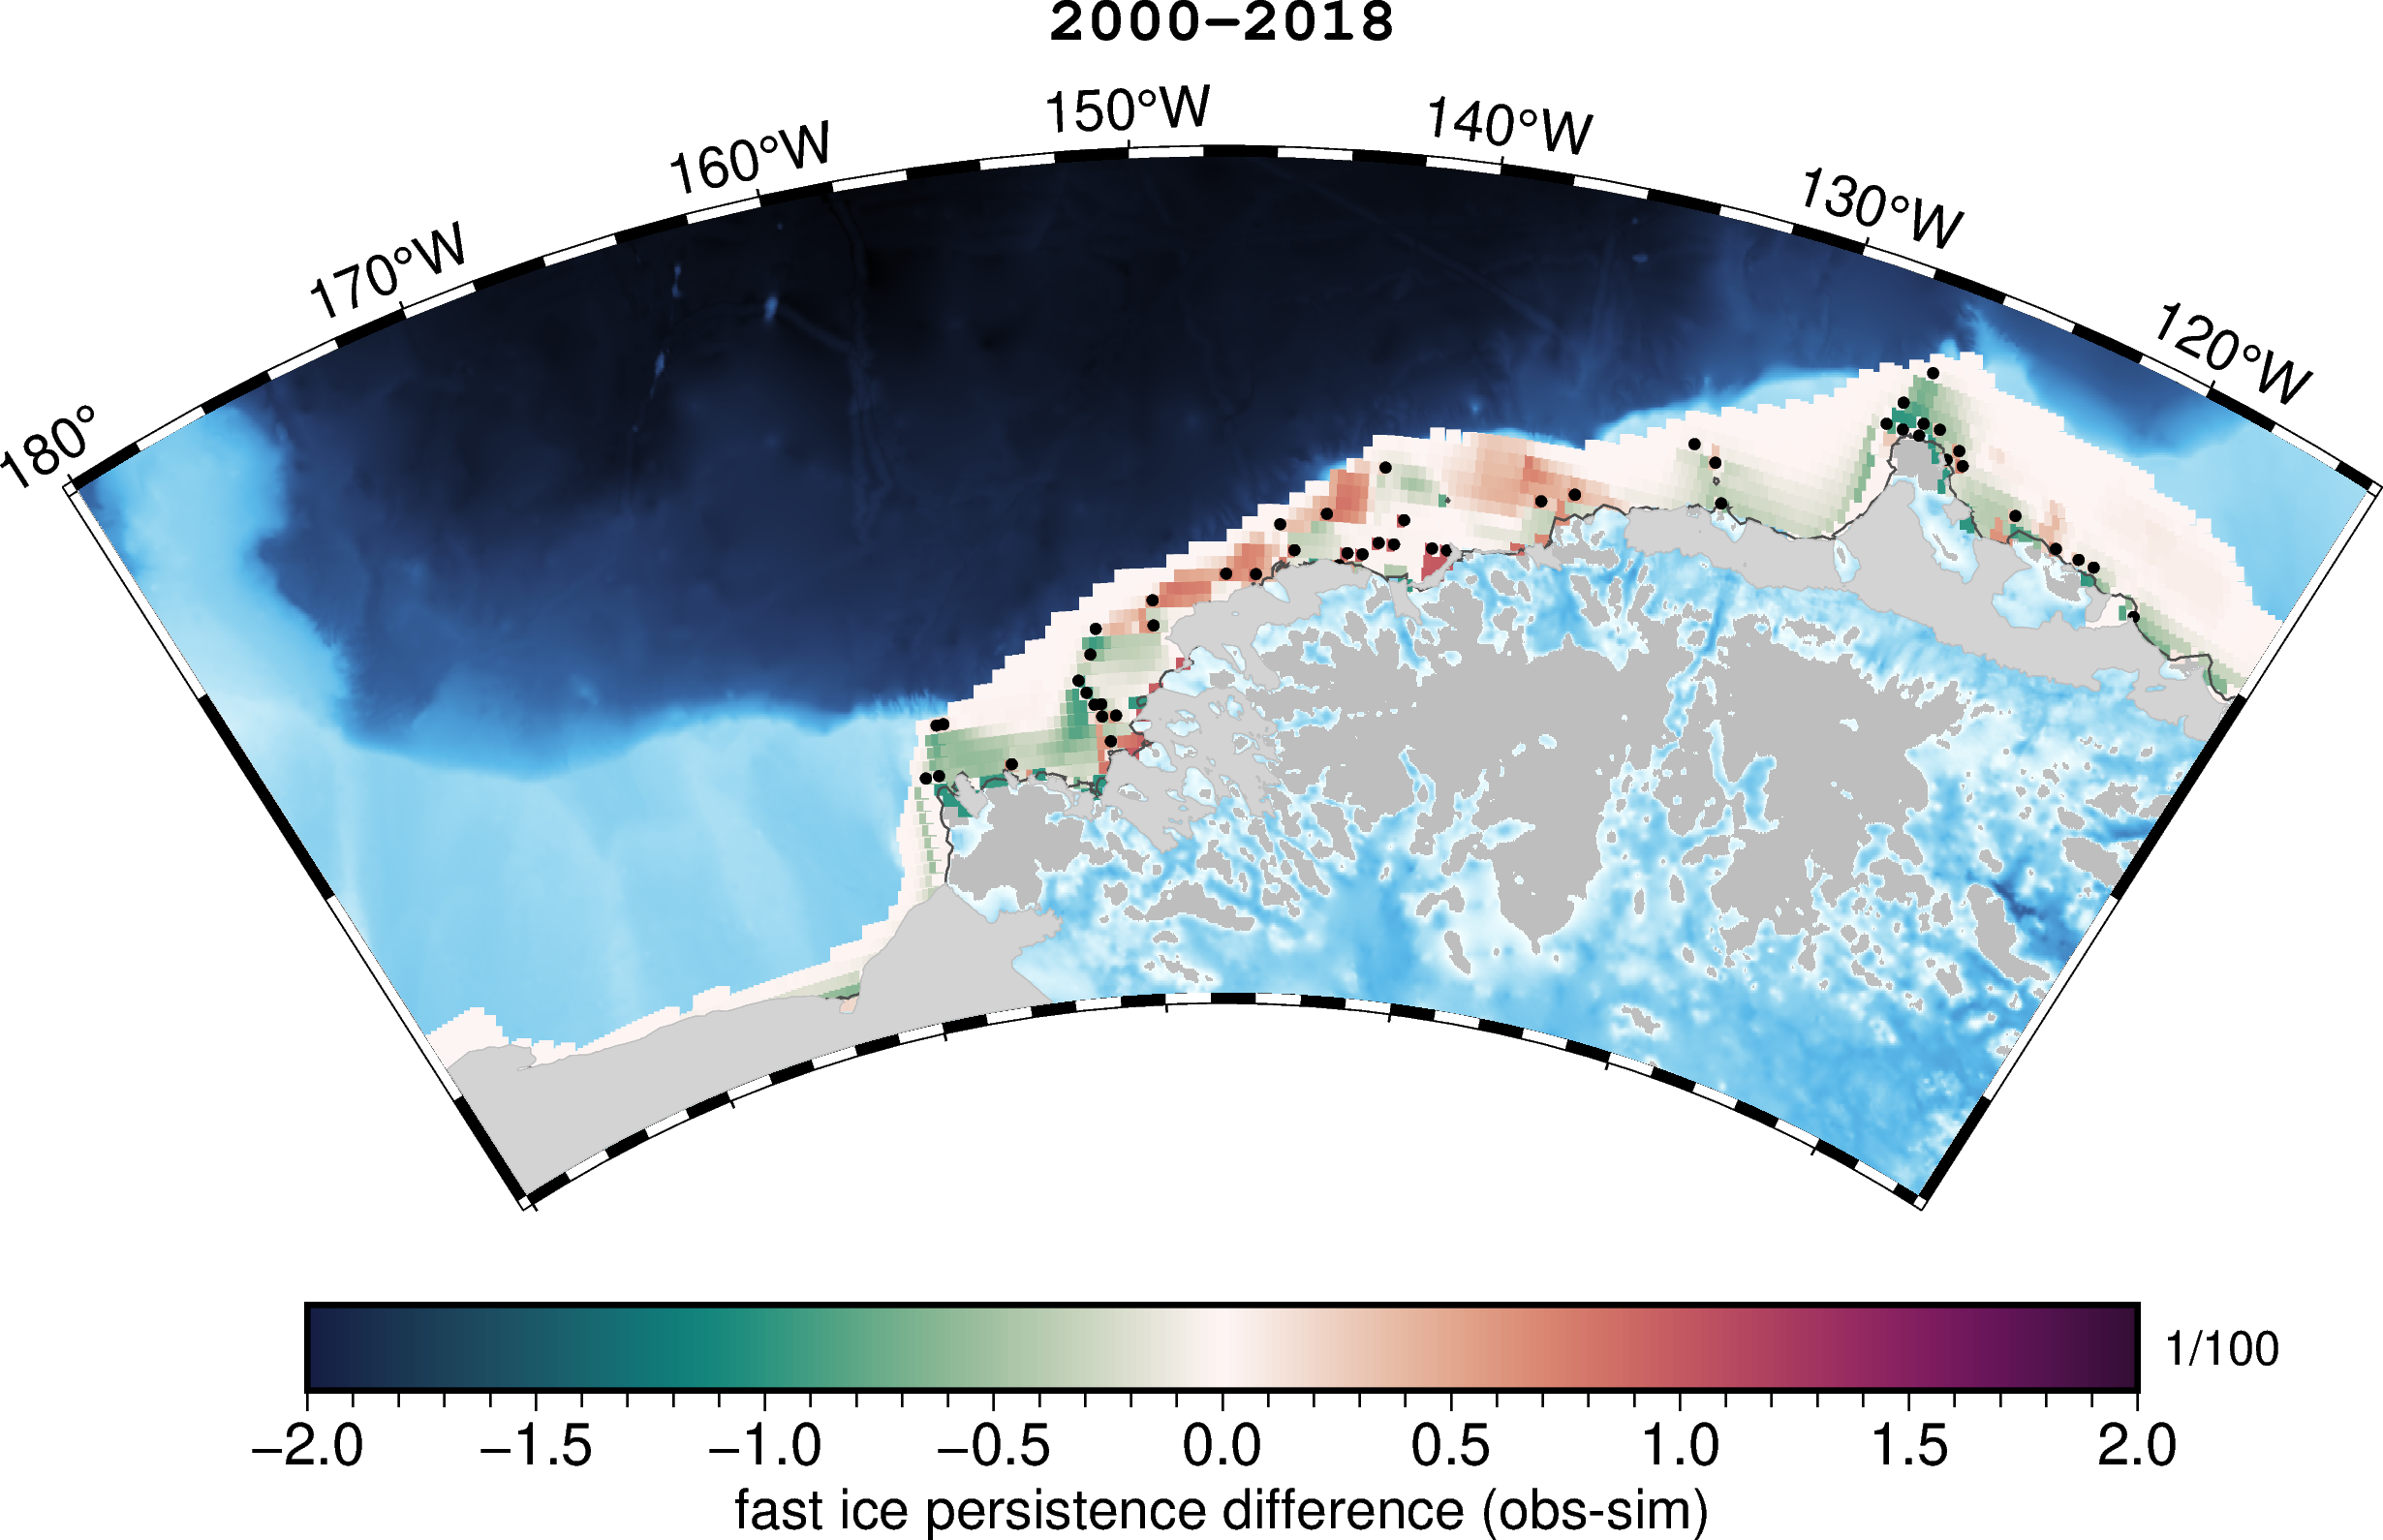

In [14]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/AS/FIP_delta/2000-2018_elps-min_AS_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/Aus/FIP_delta/2000-2018_elps-min_Aus_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/BS/FIP_delta/2000-2018_elps-min_BS_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/DML/FIP_delta/2000-2018_elps-min_DML_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/EIO/FIP_delta/2000-2018_elps-min_EIO_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/VOL/FIP_delta/2000-2018_elps-min_VOL_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/WIO/FIP_delta/2000-2018_elps-min_WIO_FIP_delta.png")

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/elps-min/WS/FIP_delta/2000-2018_elps-min_WS_FIP_delta.png")

## Which CICE parameter(s) is the model most sensitive to?

1.  rheological parameters

2.  What is the optimal concentration of grounded icebergs that should
    be used?

3.  Is there a relationship between sea ice speed threshold and fast ice
    area?

2025-07-02 17:51:14,152 - WARNING - Dask client already exists but was not passed to SeaIceToolbox.
2025-07-02 17:51:14,155 - WARNING - Please explicitly pass the existing Dask client using `client=...` to avoid confusion.
2025-07-02 17:51:14,158 - INFO - Dask distributed client can be accessed at url /proxy/40329/status
INFO:ndte-min:Dask distributed client can be accessed at url /proxy/40329/status
2025-07-02 17:51:14,160 - INFO - hemisphere initialised: SH
INFO:ndte-min:hemisphere initialised: SH
2025-07-02 17:51:14,290 - WARNING - Dask client already exists but was not passed to SeaIceToolbox.
2025-07-02 17:51:14,293 - WARNING - Please explicitly pass the existing Dask client using `client=...` to avoid confusion.
2025-07-02 17:51:14,295 - INFO - Dask distributed client can be accessed at url /proxy/40329/status
INFO:ndte-max:Dask distributed client can be accessed at url /proxy/40329/status
2025-07-02 17:51:14,297 - INFO - hemisphere initialised: SH
INFO:ndte-max:hemisphere initia

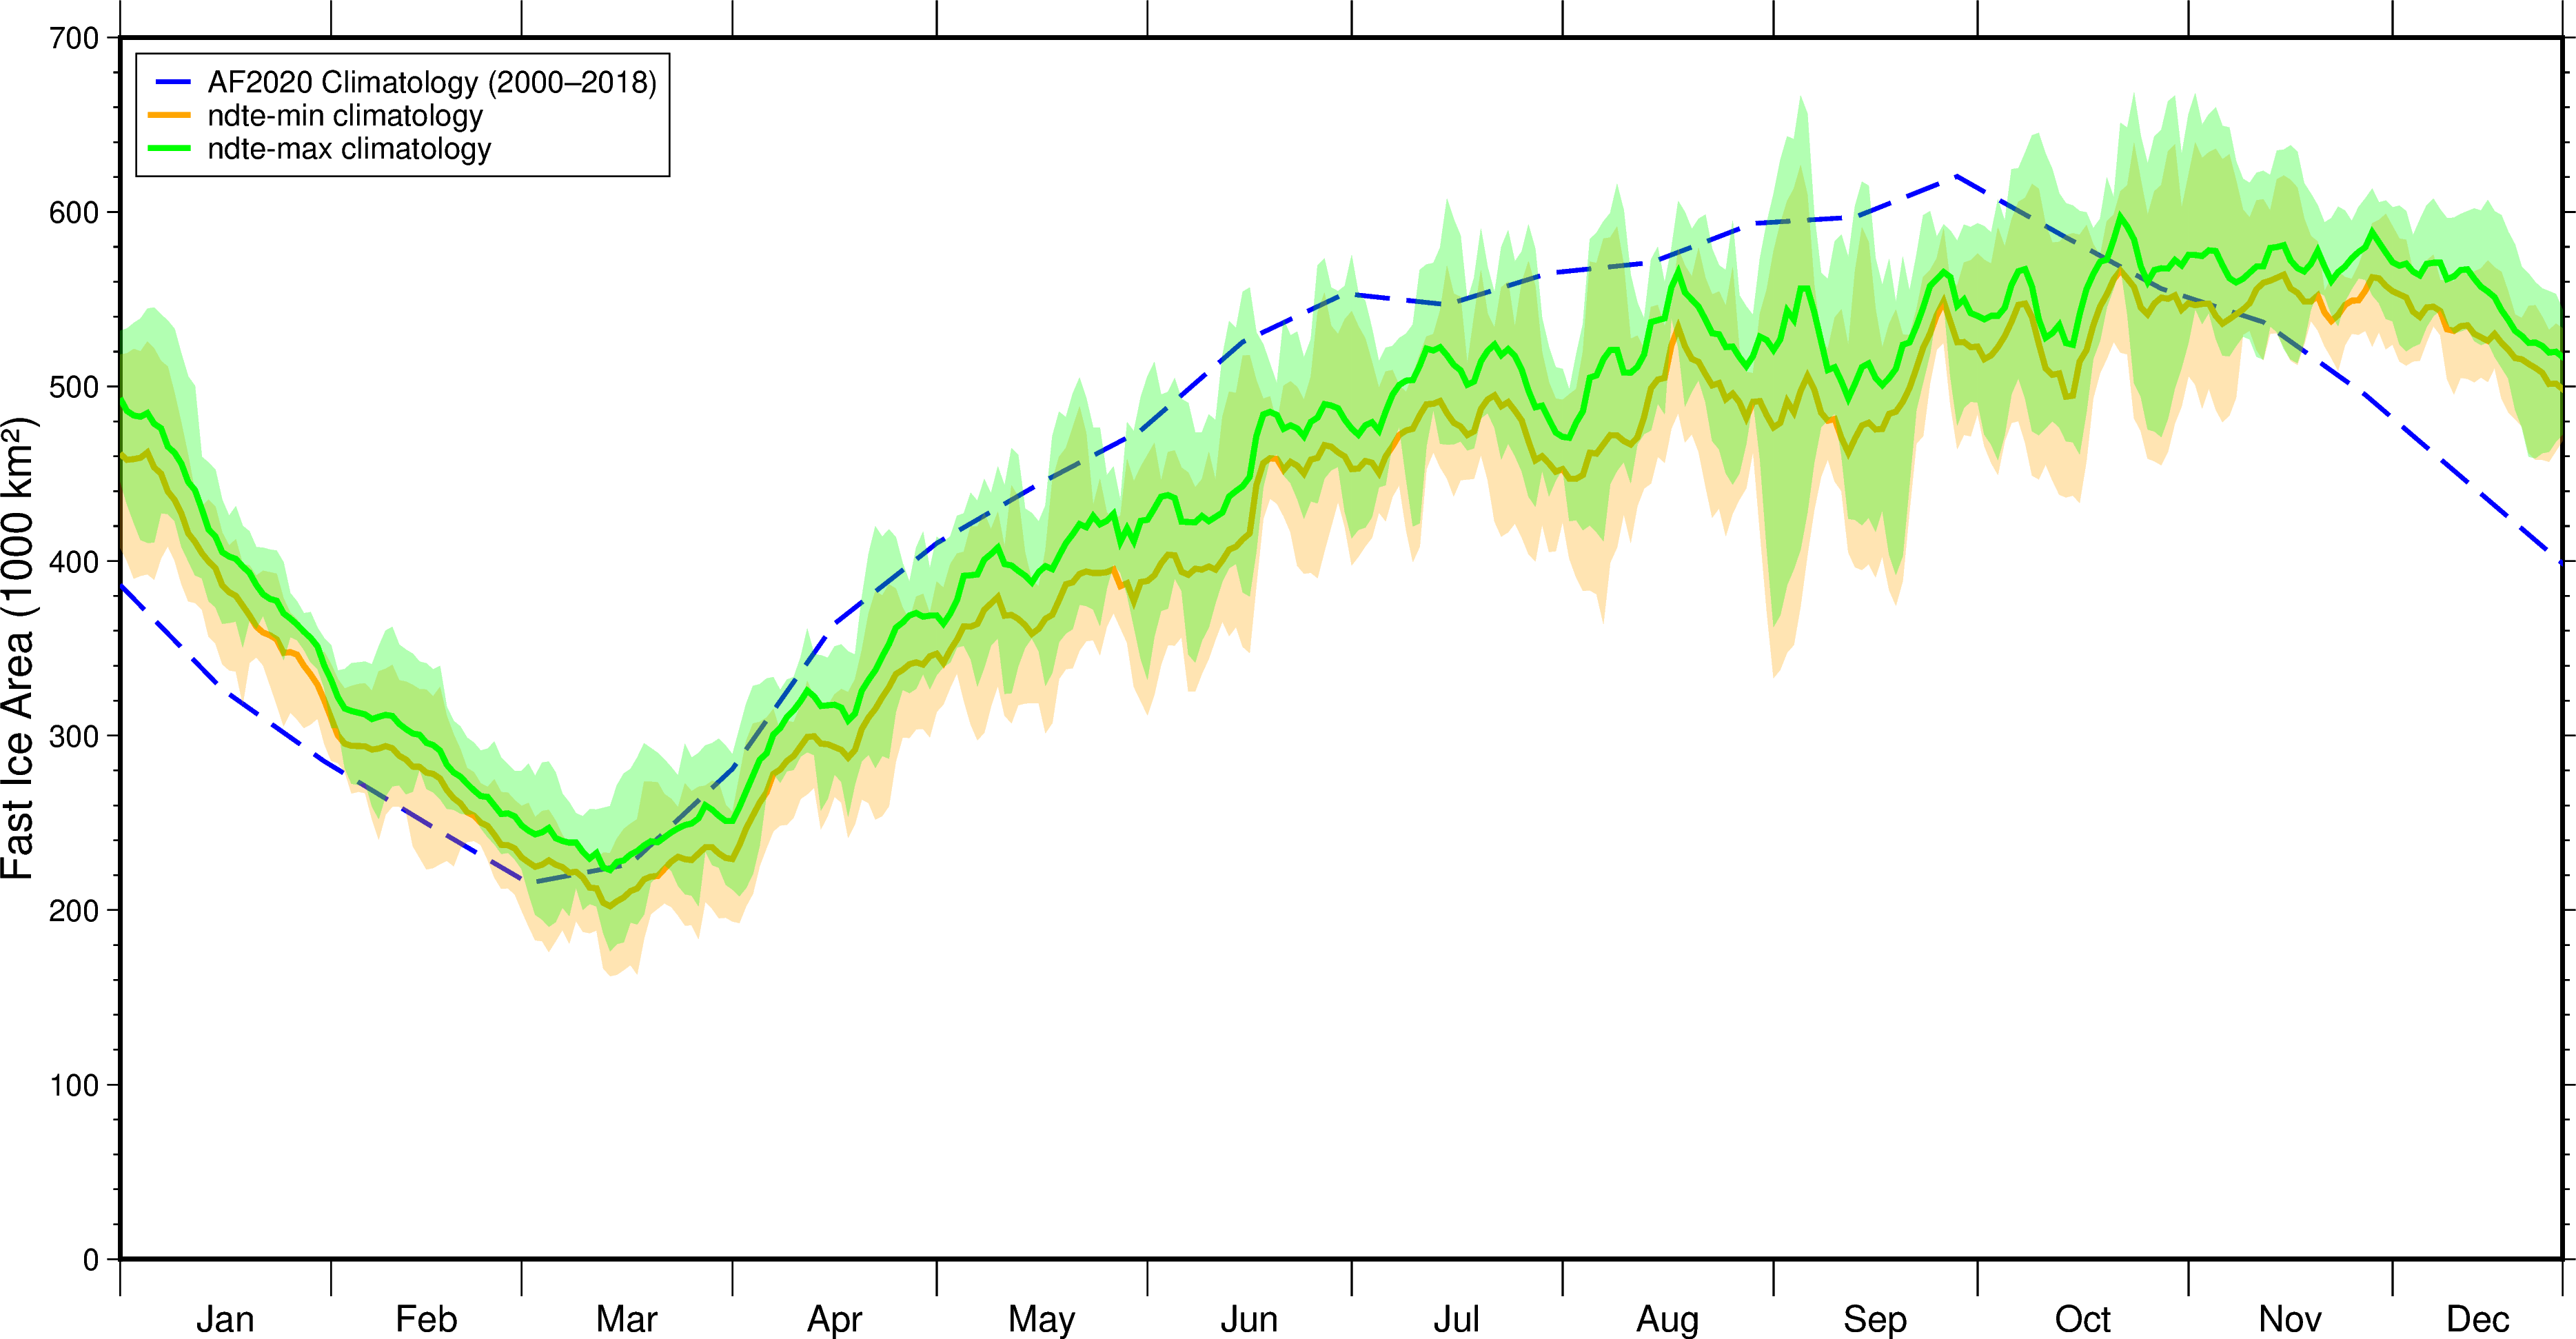

In [28]:
FIA_dict = {}
for sim_name in ["ndte-min","ndte-max"]:
    SI_tools = SeaIceToolbox(sim_name = sim_name)
    mets = xr.open_dataset(f"/g/data/gv90/da1339/afim_output/{sim_name}/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr", engine="zarr")
    FIA_dict[sim_name] = mets['FIA']
    #SI_tools.client.close()
SI_tools.plot_FIA_FIP_faceted(FIA_dict, None,
                              dt_range_str   = "1993-1999",
                              P_png          = Path("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_ndte_comparison.png"),
                              enable_FIA     = True,
                              enable_FIP     = False,
                              show_fig       = True,
                              overwrite_fig  = True,
                              FIA_ylim       = [0,700])

### Comparison of internal stress parameter $C^\ast$ 

(``Cstar-min`` : $C^\ast = 10$ and ``Cstar-max`` : $C^\ast = 30$), other parameters $e=2.0$, $k_t=0.2$, $GI-thin=0.25$

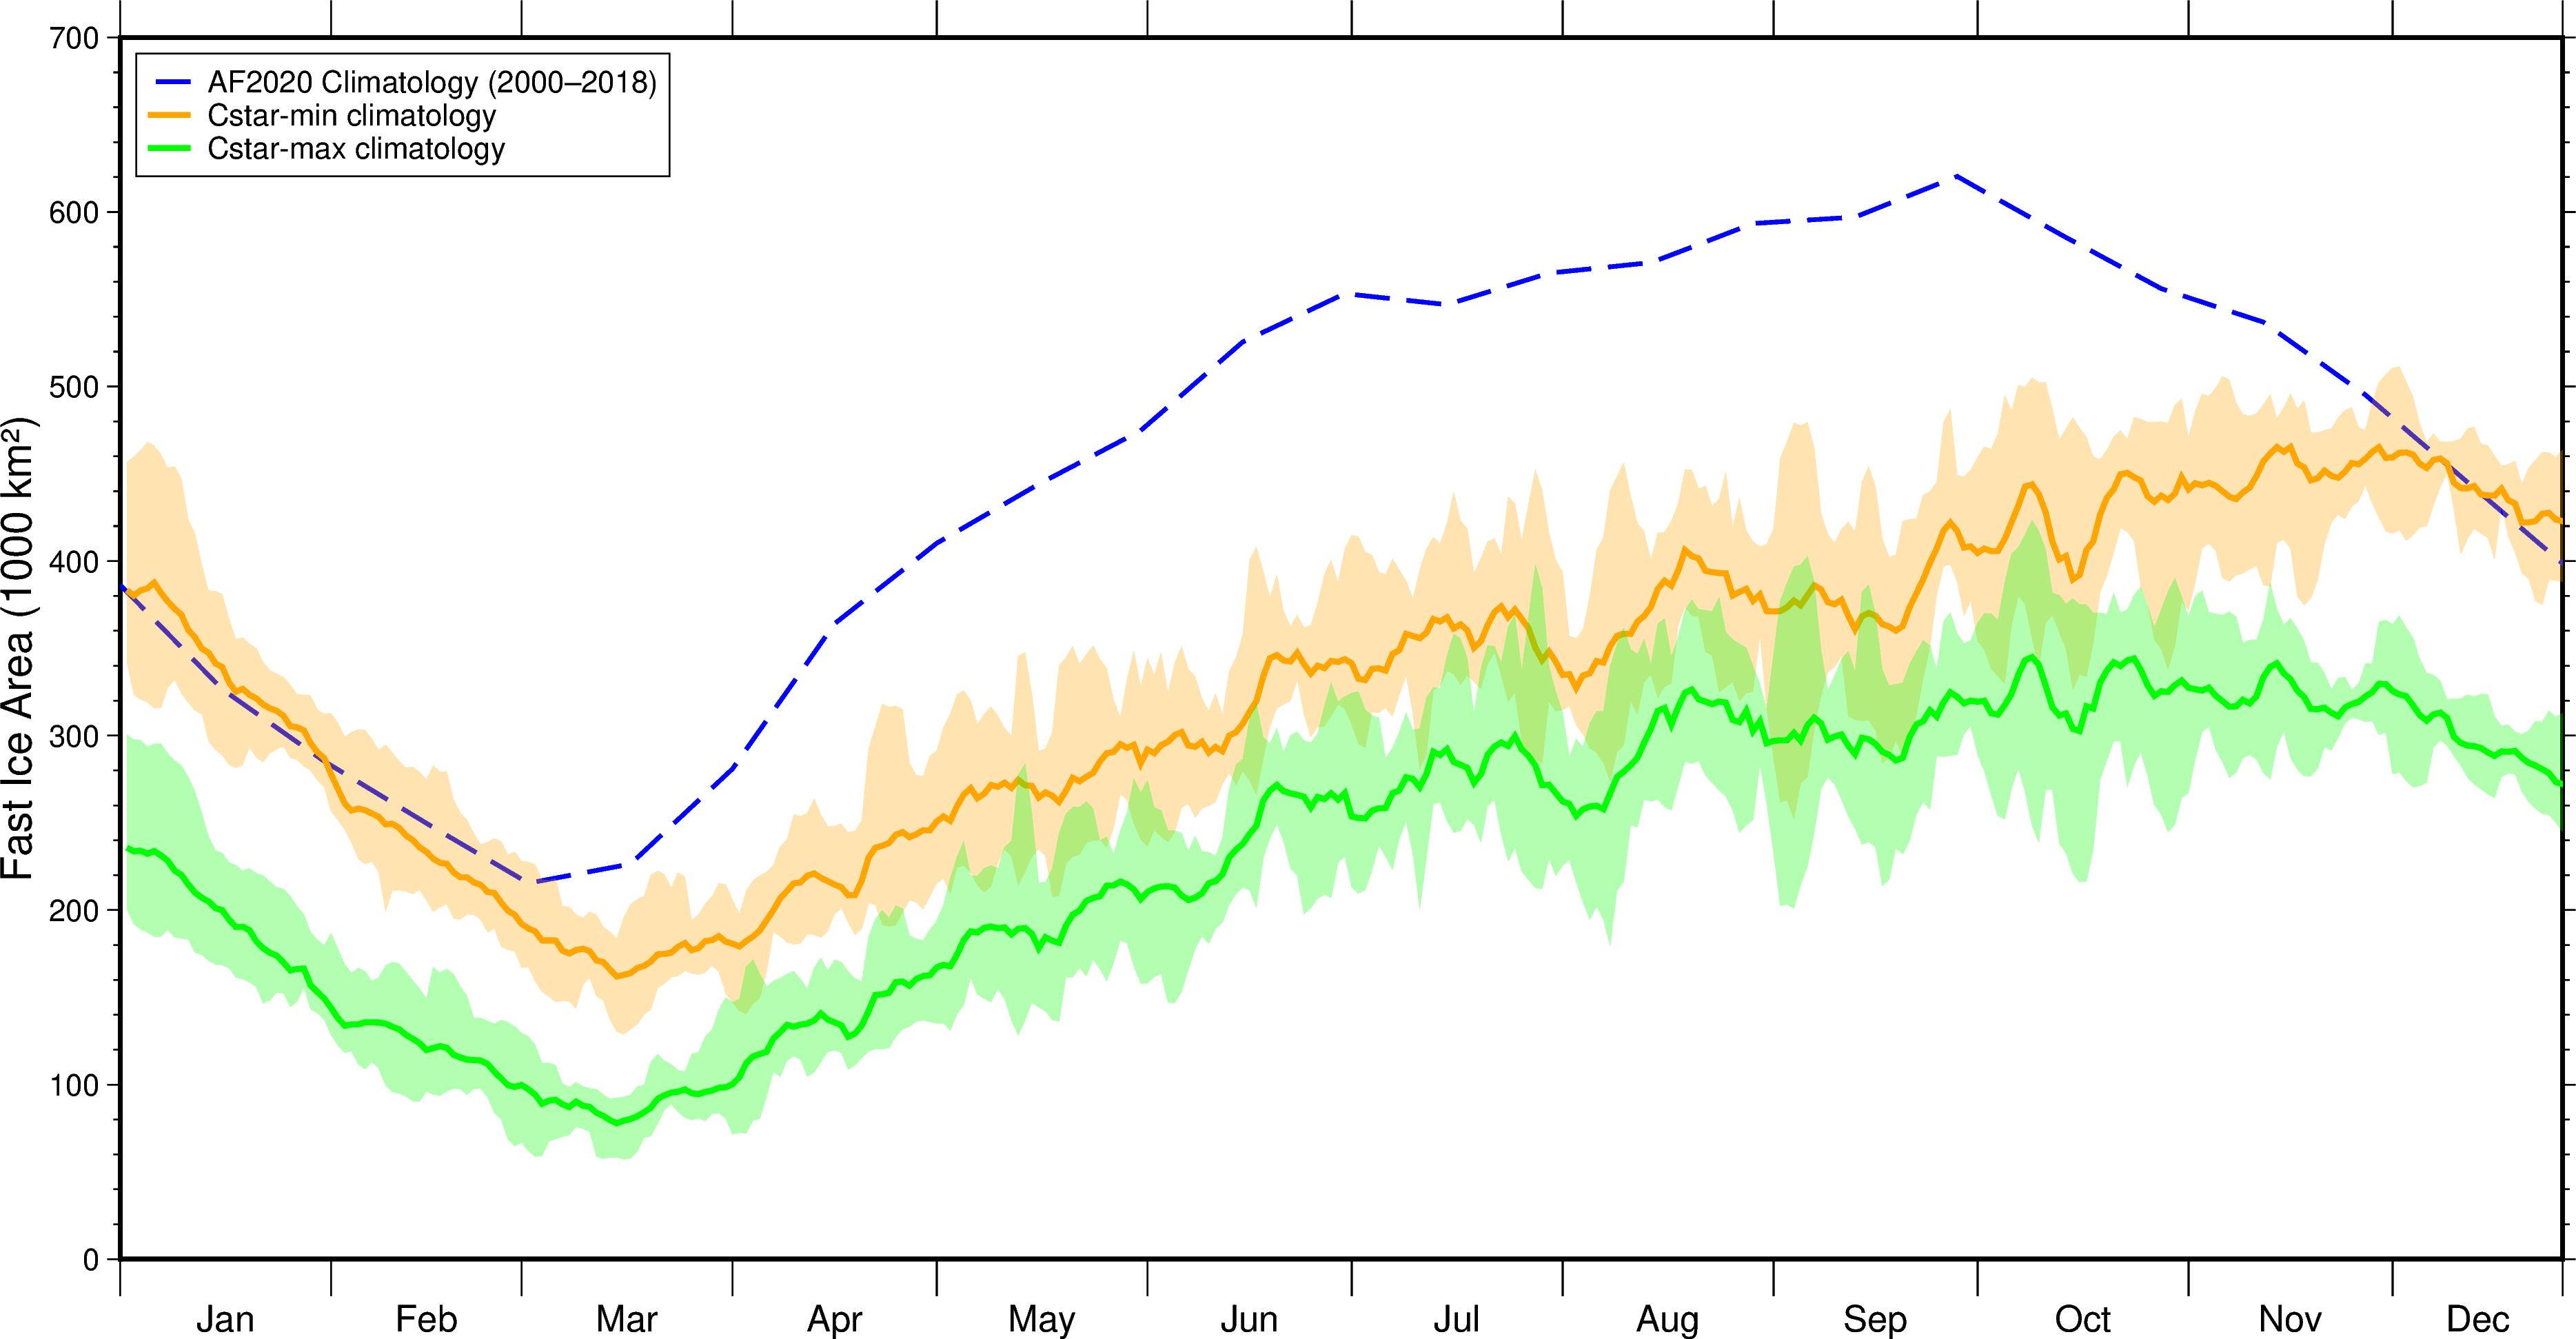

In [15]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_Cstar_comparison.png")

### Comparison of internal stress parameter $P^\ast$

(``Pstar-min`` : $P^\ast = 5\times10^4$ and ``Pstar-max`` : $P^\ast = 1\times10^4$), other parameters $e=2.0$, $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_Pstar_comparison.png")

### Comparison of tensile stress $k_t$

(``ktens-nil`` : $k_t = 0$, ``ktens-min`` : $k_t = 0.1$, ``ktens-max`` : $k_t = 0.3$, ``ktens-ext`` : $k_t = 0.6$), other parameters $e=2.0$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_ktens_comparison.png")

### Comparison of ellipse eccentricity

(``elps-max`` : $e = 2.5$, ``elps-mid`` : $e = 1.6$, ``elps-min`` : $e = 1.2$, ``elps-ext`` : $e = 0.8$), other parameters $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_elps_comparison.png")

### Comparison of grounded iceberg concentrations

(``gi-nil`` : $GI_{thin} = 0$, ``gi-min`` : $GI_{thin} = 0.15$, ``gi-mid`` : $GI_{thin} = 0.25$, ``gi-max`` : $GI_{thin} = 0.35$), other parameters $e=2.0$, $k_t=0.2$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_GI-con_comparison.png")

### Comparison of grounded iceberg ensembles runs

(``elps-min-gi1``, ``elps-min-gi2`` ``elps-min-gi3``), other parameters $e=2.0$, $k_t=0.2$ $GI_{thin}=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_GI-var_comparison.png")

### Comparison of sub-cycle iterations

(``ndte``) (``gi-mid`` : ``ndte``$=240$, ``ndte-min`` : ``ndte`` $=120$, ``ndte-max`` : ``ndte``$=720$), other parameters $e=2.0$, $k_t=0.2$, $GI-thin=0.25$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_ndte_comparison.png")

### Effect of turning off ``revised-EVP``

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_re-EVP_comparison.png")

### The of turning on Rothrock internal ice strength formulation (``kstrength``$=1$) and then tuning Rothrock ice strength parameter $Cf$.

``Roth-cf-def`` $Cf=17$, ``Roth-cf-min`` $Cf=10$, and ``Roth-cf-max`` $Cf=24$

In [ ]:
Image("/g/data/gv90/da1339/GRAPHICAL/AFIM/timeseries/FIA_Roth_comparison.png")

## Do the thermodynamics and mechanical dynamics continue to \`\`behave\'\' when CICE is *heavily tuned* for fast ice?

(limited due to standalone configuration)

## Is there a relationship between sea ice speed threshold and fast ice area?

Error with /g/data/gv90/da1339/afim_output/elps-min/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr: year must not be empty
Error with /g/data/gv90/da1339/afim_output/elps-min/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_roll_mets.zarr: year must not be empty


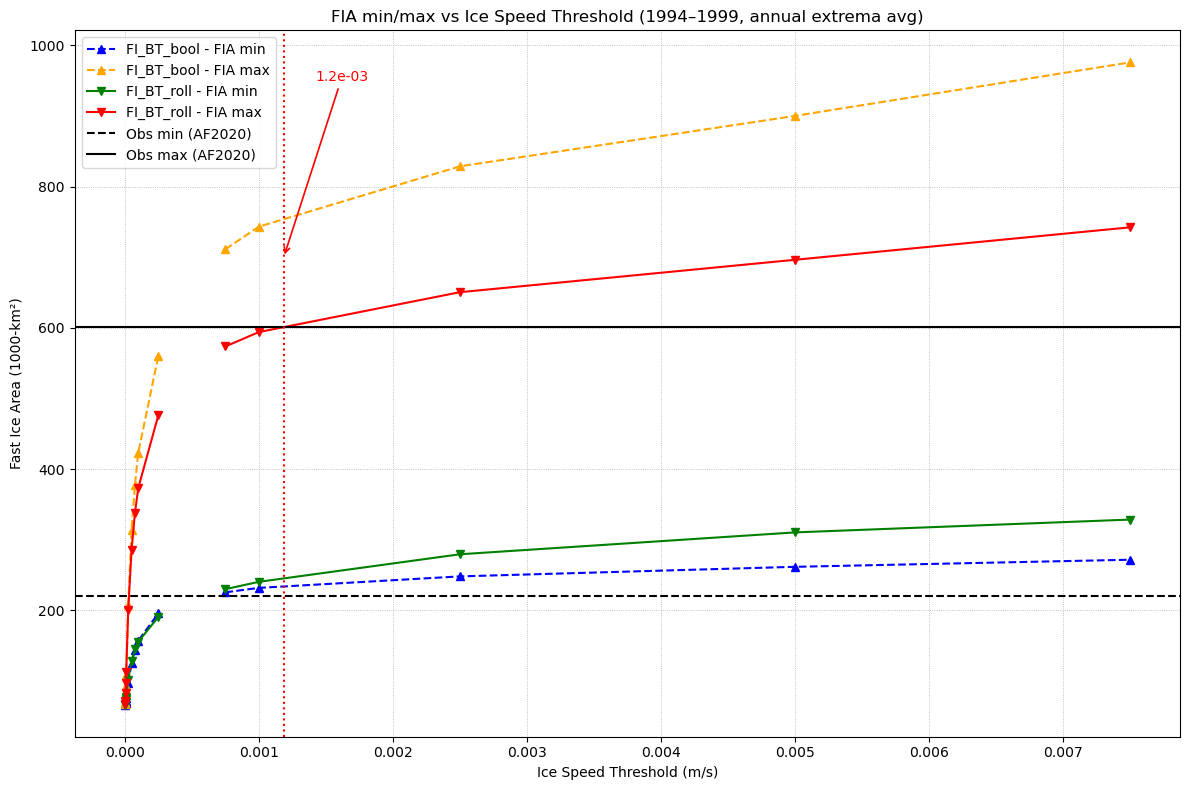

In [18]:
log_scale = False  # Set to False for linear
if log_scale:
    F_name = "ispd-thresh_vs_FIA-min-max_logscale.png"
else:
    F_name = "ispd-thresh_vs_FIA-min-max.png"
sim_name = "elps-min"
base_dir = f"/g/data/gv90/da1339/afim_output/{sim_name}/zarr"
threshold_dirs = sorted([d for d in os.listdir(base_dir) if d.startswith("ispd_thresh_")])
ispd_vals = [float(d.split('_')[2]) for d in threshold_dirs]
FIA_stats = {"FI_BT_bool": {},
             "FI_BT_roll": {}}
def get_fia_stats(path):
    try:
        ds = xr.open_zarr(path)
        fia = ds["FIA"].sel(time=slice("1994-01-01", "1999-12-31"))
        # Group by year and compute annual min/max
        fia_by_year = fia.groupby("time.year")
        min_by_year = fia_by_year.min(dim="time")
        max_by_year = fia_by_year.max(dim="time")
        # Compute the mean of annual min/max
        return float(min_by_year.mean().values), float(max_by_year.mean().values)
    except Exception as e:
        print(f"Error with {path}: {e}")
        return np.nan, np.nan
# Define a function to interpolate where the method curve crosses the observed value
def interpolate_x(x, y, y_obs):
    x = np.array(x)
    y = np.array(y)
    for i in range(len(x) - 1):
        if np.isnan(y[i]) or np.isnan(y[i + 1]):
            continue
        if (y[i] - y_obs) * (y[i + 1] - y_obs) < 0:
            # Linear interpolation in log or linear space depending on axis setting
            return x[i] + (y_obs - y[i]) * (x[i + 1] - x[i]) / (y[i + 1] - y[i])
    return None

for dir_name in threshold_dirs:
    threshold = float(dir_name.split("_")[2])
    # Paths
    bool_path = os.path.join(base_dir, dir_name, "metrics", "FI_BT_bool_mets.zarr")
    roll_path = os.path.join(base_dir, dir_name, "metrics", "FI_BT_roll_mets.zarr")
    # Load stats
    min_b, max_b = get_fia_stats(bool_path)
    min_r, max_r = get_fia_stats(roll_path)
    # Store in dict
    FIA_stats["FI_BT_bool"][threshold] = {"min": min_b, "max": max_b}
    FIA_stats["FI_BT_roll"][threshold] = {"min": min_r, "max": max_r}

# Observed min/max
obs_min = 221
obs_max = 601

# Sort thresholds
thresholds = sorted(FIA_stats['FI_BT_bool'].keys())

# Prepare data
bool_min = [FIA_stats['FI_BT_bool'][t]['min'] for t in thresholds]
bool_max = [FIA_stats['FI_BT_bool'][t]['max'] for t in thresholds]
roll_min = [FIA_stats['FI_BT_roll'][t]['min'] for t in thresholds]
roll_max = [FIA_stats['FI_BT_roll'][t]['max'] for t in thresholds]
# Compute interpolated x-values for each intersection
bool_min_x = interpolate_x(thresholds, bool_min, obs_min)
bool_max_x = interpolate_x(thresholds, bool_max, obs_max)
roll_min_x = interpolate_x(thresholds, roll_min, obs_min)
roll_max_x = interpolate_x(thresholds, roll_max, obs_max)

plt.figure(figsize=(12, 8))
if log_scale:
    plt.xscale("log")
    plt.yscale("log")

# Plot the curves
plt.plot(thresholds, bool_min, 'b--', marker='^', label="FI_BT_bool - FIA min")
plt.plot(thresholds, bool_max, 'orange', linestyle='--', marker='^', label="FI_BT_bool - FIA max")
plt.plot(thresholds, roll_min, 'g-', marker='v', label="FI_BT_roll - FIA min")
plt.plot(thresholds, roll_max, 'r-', marker='v', label="FI_BT_roll - FIA max")

# Horizontal obs lines
plt.axhline(obs_min, color='k', linestyle='--', label="Obs min (AF2020)")
plt.axhline(obs_max, color='k', linestyle='-', label="Obs max (AF2020)")

# Arrow annotations for vertical thresholds
arrowprops = dict(arrowstyle="->", linewidth=1.2)

if bool_min_x:
    plt.axvline(bool_min_x, color='blue', linestyle=':')
    plt.annotate(f"{bool_min_x:.1e}",
                 xy=(bool_min_x, 250), xytext=(bool_min_x * 1.2, 400),
                 arrowprops={**arrowprops, 'color': 'blue'}, color='blue')

if bool_max_x:
    plt.axvline(bool_max_x, color='orange', linestyle=':')
    plt.annotate(f"{bool_max_x:.1e}",
                 xy=(bool_max_x, 800), xytext=(bool_max_x * 1.2, 1000),
                 arrowprops={**arrowprops, 'color': 'orange'}, color='orange')

if roll_min_x:
    plt.axvline(roll_min_x, color='green', linestyle=':')
    plt.annotate(f"{roll_min_x:.1e}",
                 xy=(roll_min_x, 250), xytext=(roll_min_x * 1.2, 500),
                 arrowprops={**arrowprops, 'color': 'green'}, color='green')

if roll_max_x:
    plt.axvline(roll_max_x, color='red', linestyle=':')
    plt.annotate(f"{roll_max_x:.1e}",
                 xy=(roll_max_x, 700), xytext=(roll_max_x * 1.2, 950),
                 arrowprops={**arrowprops, 'color': 'red'}, color='red')

# Labels and formatting
plt.xlabel("Ice Speed Threshold (m/s)")
plt.ylabel("Fast Ice Area (1000-km²)")
plt.title("FIA min/max vs Ice Speed Threshold (1994–1999, annual extrema avg)")
plt.legend()
plt.grid(True, which='both' if log_scale else 'major', linestyle=':', linewidth=0.6)
plt.tight_layout()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/AFIM/{sim_name}/{F_name}")
plt.show()